# README

This program takes D-PV time series data of a certain site in a certain date, and detect tripping, VVAr, VWatt response, and their curtailment.

# IMPORT LIBRARY AND PACKAGES

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pytz #for timezone calculation
import math
import matplotlib.dates as md
import gc
import os
from datetime import datetime
%matplotlib qt
%matplotlib inline

# SET GLOBAL PARAMETERS

In [2]:
# ================== Global parameters for fonts & sizes =================
FONT_SIZE = 20
rc={'font.size': FONT_SIZE, 'axes.labelsize': FONT_SIZE, 'legend.fontsize': FONT_SIZE, 
    'axes.titlesize': FONT_SIZE, 'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
plt.rcParams.update(**rc)
plt.rc('font', weight='bold')
 
# For label titles
fontdict={'fontsize': FONT_SIZE, 'fontweight' : 'bold'}
# can add in above dictionary: 'verticalalignment': 'baseline' 

style = 'ggplot' # choose a style from the above options
plt.style.use(style)

# ENERGY GENERATED CALCULATION

In [3]:
def check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy):
    """Get the amount of energy generated in a certain site in a certain day, unit kWh.
    energy_generated, energy_generated_expected, estimation_method = check_energy_generated(data_site, date, is_clear_sky_day)

    Args:
        data_site (df): Cleaned D-PV time-series data, output of site_orgaize function
        date (str): date in focus
        is_clear_sky_day (bool): whether the date is a clear sky day or not
        tripping_curt_energy (float): the amount of energy curtailed due to tripping response

    Returns:
        energy_generated (float): Single value of the total energy generated in that day
        data_site (df): D-PV time series data with updated 'power_expected' column if the there is tripping in a non clear sky day.
    """
    
    #sh_idx = (data_site.index.hour>= 7) & (data_site.index.hour <= 17)
    #hour filter should not be necessary since outside of that hour, the power is zero anyway.
    
    date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
    date_idx = data_site.index.date == date_dt
    energy_generated = data_site.loc[date_idx, 'power'].resample('h').mean().sum()/1000
    
    if not is_clear_sky_day:
        data_site['power_expected'] = data_site['power_expected_linear']
        
    return energy_generated, data_site

def check_energy_expected_generated(data_site, date):
    """Get the amount of expected energy generated in a certain site in a certain day, unit kWh.

    Args:
        data_site (df): Cleaned D-PV time-series data, with power_expected column
        date (str): date in focus

    Returns:
        energy_generated_expected (float): Single value of the total expected energy generated in that day
    """
    
    #sh_idx = (data_site.index.hour>= 7) & (data_site.index.hour <= 17)
    #hour filter should not be necessary since outside of that hour, the power is zero anyway.
    
    date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
    date_idx = data_site.index.date == date_dt
    energy_generated_expected = data_site.loc[date_idx, 'power_expected'].resample('h').mean().sum()/1000
    return energy_generated_expected

# CHECK CLEAR SKY DAY


In [4]:
def check_clear_sky_day(date):
    """Check whether a certain date is a clear sky day based on the ghi data of that day. Needs ghi data.

    Args:
    date (str): dat ein YYYYMMDD format

    Returns:
    clear_sky_day (bool): is it a clear sky day or not
    
    Funcitons needed:
    - get_timestamp_date_string
    - separate_ghi_data
    - detect_clear_sky_day

    We say that a certain day is a clear sky day
    if the ghi profile seems to be smooth. Check detect_clear_sky_day for details. It is important to note, however,
    it is possible for a site in a clear sky day to be not having a clear power profile in the D-PV data. This is
    because the location of the ghi observation station can be a bit far from the actual site. 
    
    IDEA: Probably it will be nice to determine whether a site is a clear sky day from the power profile and not the 
    ghi profile?
    """
    
    dateFile = date[:4]+'_'+ date[5:7]
    ghi = pd.read_csv(file_path +'/sl_023034_' + dateFile + ".txt")
    timestamp_date_string = get_timestamp_date_string(dateFile)
    separated_ghi_data = separate_ghi_data(timestamp_date_string, ghi)
    ghi_df = separated_ghi_data[date]
    res, average_delta_y = detect_clear_sky_day(ghi_df, 530)

    if res:
        #clear_sky_days.append(date)
        #overall_clear_sky_days_dict[dateFile].append(date)
        is_clear_sky_day = True
    else:
        is_clear_sky_day = False
    return is_clear_sky_day

# TRIPPING CURTAILMENT PROGRAM

In [5]:
#IDEA: Probably it will be nice if we can build the program from scratch and removing all redundancy especially in the 
#beginning where we copy the data_site into some new variables.

#customized module to calculate the first derivative of the power data

#BELOW IS ADAPTED FROM NAOMI'S ALGORITHM 
import util #there has to be util.py in the same directory

def rcount(a):
    """Function for getting cumulative count of 0 with reset on 1

    Args:
    a (pd series): a series with 0 and 1 values

    Returns:
    result (int): cumulative count of 0 with reset on 1
    """
    
    without_reset = (a == 0).cumsum()
    reset_at = (a == 1)
    overcount = np.maximum.accumulate(without_reset * reset_at)
    result = without_reset - overcount
    return result

def filter_sunrise_sunset(df):
    """Filter a D-PV Time series data based on its estimated sunrise and sunset time.

    Args:
    df (df): D-PV Time series data with 'power' column

    Returns:
    sunrise (timestamp): estimated sunrise time (when power is >10 W for the first time in a day)
    sunset (timestamp): the opened ghi data (when power is >10 W for the last time in a day)
    df (df): filtered D-PV Time series data
    
    The sunrise and sunset time may be inaccurate in a cloudy morning or evening. However, it should not
    affect the result because we only care about the power produced by the PV system. 
    """
    
    LIMIT_DAY_POWER = 10
    if df is None or len(df.index) == 0:
        return None, None, None

    tmp_df = df.loc[df['power'] > LIMIT_DAY_POWER]
    if len(tmp_df.index) == 0:
        return None, None, None

    sunrise = tmp_df.index[0]
    sunset = tmp_df.index[-1]

    df = df.loc[df.index > sunrise]
    df = df.loc[df.index < sunset]

    return sunrise, sunset, df

def filter_sunrise_sunset_2(df):
    """Filter a D-PV Time series data based on its estimated sunrise and sunset time, for Naomi's data format.

    Args:
    df (df): D-PV Time series data

    Returns:
    sunrise (timestamp): estimated sunrise time (when power is >10 W for the first time in a day)
    sunset (timestamp): the opened ghi data (when power is >10 W for the last time in a day)
    df (df): filtered D-PV Time series data
    
    Basically similar function with filter_sunrise_sunset, unless we use kW in the power column instead of watt. 
    """
    
    LIMIT_DAY_POWER = 10
    if df is None or len(df.index) == 0:
        return None, None, None

    tmp_df = df.loc[df['power_kW'] > LIMIT_DAY_POWER/1000] #divided by 1000 because in kW
    if len(tmp_df.index) == 0:
        return None, None, None

    sunrise = tmp_df.index[0]
    sunset = tmp_df.index[-1]

    df = df.loc[df.index > sunrise]
    df = df.loc[df.index < sunset]

    return sunrise, sunset, df

def check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date):
    """Check the tripping response and the amount of energy curtailed bcs of tripping in kWh for certain data and site.

    Args:
    is_clear_sky_day (bool) : is the certain date a clear sky date or not
    c_id (str): c_id
    data_site (df): Cleaned D-PV time-series data, output of site_organize function
    unique_cids (df): Unique c_id and site_id data
    ac_cap (float): Inverter capacity in watt
    site_details (df): Site data from unsw_20190701_site_details.csv and unsw_20190701_circuit_details.csv
    date (str): Date in YYYYMMDD

    Returns:
    tripping_response (str): Yes or None, whether there is a tripping response by the inverter
    tripping_curt_energy (float): The amount of energy curtailed in that date and site in kWh
    estimation_method (str): Linear or polyfit. Polyfit is only used when it is a clear sky day and the fit passes 
                             some criterias. Otherwise always use linear.
    data_site (df): D-PV time series data with a new column: 'power_expected_linear' which is the estimated power 
                    production without curtailment, estimated using linear method. 
    

    Some parts are modified to be compatible for SolA dataset input and implementation
    together with VVAr and VWatt script.
    
    TODO: Reconsider whether the cleaning part of Naomi's script is still necessary in Baran's SolA dataset.
    TODO: Compare between Naomi's and Tim's polyfit algorithm, pick the better one, upgrade it.
    """
    
    # In Naomi's script, the first step is to clean the data (remove duplicates, convert to numeric, etc). However, since the inputted data here is already cleaned, we directly use the data without further cleaning process.
    # Approx capacity factor value considered to be 'zero', e.g. less than 1% CF is zero.

    # List of connection types for filtering
    pv_list = ['pv_site_net', 'pv_site', 'pv_inverter_net']
    CF_ZERO_APPROX = 0.01

    # Approx cf derivative at which considered to be 'ramp'. That is, for at least a 10% change in capacity factor (ABSOLUTE!) expect to be ramping up or down.
    # Note, only applied 'next to' zeros. So should not capture shading effects.
    FIRST_DERIV_FALL_LIMIT = -0.05
    FIRST_DERIV_INCREASE_LIMIT = 0.05
    # For missing data check
    ALLOWED_MISSING_DATA_PERCENTAGE = 0.05
    # Average percentage of capacity at which a system must operate over the course of the day in order to be included in analysis
    VERY_LOW_OUTPUT_AVE_PERCENTAGE_CAPACITY = 0.05


    # Get data
    unaltered_data = pd.DataFrame({
        'c_id' : c_id,
        'v' : data_site['voltage'],
        'd' : data_site['duration'],
        'site_id' : unique_cids.loc[unique_cids['c_id'] == c_id, 'site_id'].iloc[0],
        'e' : data_site['energy'],
        'con_type' : site_details.loc[site_details['c_id'] == c_id, 'con_type'].iloc[0],
        'first_ac' : ac_cap/1000, #IDK what is this, but let's assume it is just the same with sum_ac, which is the inverter ac capacity
        'power_kW' : data_site['power']/1000,
        'reactive_power' : data_site['reactive_power'],
        'clean' : 'cleaned',
        'manufacturer' : site_details.loc[site_details['c_id'] == c_id, 'inverter_manufacturer'].iloc[0],
        'model' : site_details.loc[site_details['c_id'] == c_id, 'inverter_model'].iloc[0],
        'sum_ac' : ac_cap/1000,
        'time_offset' : float("nan")
    }, index = data_site.index)
    unaltered_data.index.rename('ts', inplace=True) 

    # rename energy column
    unaltered_data = unaltered_data.rename(columns = {'e' : 'energy', 'd':'duration', 'sum_ac':'ac'})
    # filter for clean
    unaltered_data = unaltered_data[unaltered_data['clean']=='cleaned']
    # Attempt to fix issues by sorting the index at the beginning
    unaltered_data = unaltered_data.sort_index()
    # Change name to t_stamp
    unaltered_data.index.name = 't_stamp'
    # Add time by seconds from start of the day
    unaltered_data['hrs'] = unaltered_data.index.hour
    unaltered_data['min'] = unaltered_data.index.minute
    unaltered_data['sec'] = unaltered_data.index.second
    unaltered_data['time_in_seconds'] = unaltered_data['hrs'] * 60 * 60 + unaltered_data['min'] * 60 + unaltered_data['sec']

    '''
    # Get list of time_intervals
    time_interval_list = unaltered_data['duration'].drop_duplicates().tolist()

    # ********************* Further data cleaning [START] *********************
    # Check for missing data issues
    # TODO - this may not longer work since the Solar Analytics data can contain a mix of 60s and 5s data
    # Flag sites with too much missing data (based on threshold), need to also keep the duration
    missing_data_df = pd.DataFrame({'num_data_pts': unaltered_data.groupby('c_id')['energy'].count(), 'duration': unaltered_data.groupby('c_id')['duration'].first()}).reset_index()
    # We now have two possible time intervals: 30s or 60s.
    # Therefore, we need to run twice?
    for time_interval in time_interval_list:
        # Expected number of time periods
        num_time_periods = 24 * 60 * (60 / time_interval)
        # Get the minimum number of data points required in order to have enough data (i.e. not lots of missing data)
        missing_data_threshold = num_time_periods * (1 - ALLOWED_MISSING_DATA_PERCENTAGE)
        missing_data_df['missing_data_flag'] = np.nan
        missing_data_df.loc[(missing_data_df['num_data_pts'] <= missing_data_threshold) & missing_data_df['duration']==time_interval , 'missing_data_flag'] = 1.0
        
    '''
    
    # Merge information about missing data back onto time series df
    # unaltered_data = unaltered_data.reset_index().merge(missing_data_df, on='c_id', how='left').set_index('t_stamp')
    # Filter unaltered data for only sites with sufficient data points
    # unaltered_data = unaltered_data[unaltered_data['missing_data_flag'] != 1.0]

    # Filter for PV only
    unaltered_data = unaltered_data[unaltered_data['con_type'].isin(pv_list)]

    # First fix duratoin_x / duration_y problem. Not sure where it is coming from
    # I don't know why, but there is duration_x and duration_y. Drop one and rename the other
    #unaltered_data = unaltered_data.drop(['duration_x'], axis=1)
    #unaltered_data = unaltered_data.rename(columns={'duration_y': 'duration'})

    # Open _circuit_details_for_editing.csv file for sunrise/set times
    assist_df = pd.DataFrame({
        'c_id' : [c_id],
        'energy_day' : [float("nan")],
        'energy_night' : [float("nan")],
        'con_type' : [site_details.loc[site_details['c_id'] == c_id, 'con_type'].iloc[0]],
        'sunrise' : ['2/09/2019  6:06:06'], #this is not used anymore because we have filter_sunrise_sunset function
        'sunset' : ['2/09/2019  19:28:19'], #this is not used anymore because we have filter_sunrise_sunset function
        'min_power' : [data_site['power'].min()/1000],
        'max_power' : [data_site['power'].max()/1000],
        'polarity' : [site_details.loc[site_details['c_id'] == c_id, 'polarity'].iloc[0]],
        'frac_day' : [float('nan')],
        'old_con_type' : [float('nan')],
        'con_type_change' : [float('nan')],
        'site_id' : [unique_cids.loc[unique_cids['c_id'] == c_id, 'site_id'].iloc[0]]
    })

    # Check for PV sites with very low output and remove them
    get_site_ac_df = unaltered_data[['site_id', 'first_ac', 'ac']]
    get_site_ac_df = get_site_ac_df.drop_duplicates(subset='site_id')
    # merge keeping only the site_ids in the time series df.
    assist_df = assist_df.merge(get_site_ac_df, left_on='site_id', right_on='site_id', how='right')

    # Check whether c_ids operated at less than an average of 5% capacity
    # Compare using max power output compared with first_ac.
    max_p_df = pd.DataFrame({'max_p_kW': unaltered_data.groupby('c_id')['power_kW'].max(), 'first_ac' : unaltered_data.groupby('c_id')['first_ac'].first()})
    max_p_df['low_output_flag'] = np.nan
    max_p_df.loc[max_p_df['max_p_kW'] < VERY_LOW_OUTPUT_AVE_PERCENTAGE_CAPACITY * max_p_df['first_ac'] , 'low_output_flag'] = 1
    # Copy c_ids to a column (from index)
    max_p_df['c_id'] = max_p_df.index
    # Get list of c_ids to be excluded
    c_ids_to_WITHOUT_low_output = max_p_df[max_p_df['low_output_flag'] != 1]
    c_ids_to_WITHOUT_low_output = c_ids_to_WITHOUT_low_output['c_id'].tolist()

    # Only keep sites that have enough output
    unaltered_data = unaltered_data[unaltered_data['c_id'].isin(c_ids_to_WITHOUT_low_output)]
    # ********************* Further data cleaning [END] *********************

    # Get assist_df with c_id as index
    assist_df_c_id = assist_df.set_index('c_id')

    # Get c_id list
    c_id_list = unaltered_data['c_id'].drop_duplicates().tolist()
    # Set up output_df
    output_df = pd.DataFrame()
    output_df.index.name = 't_stamp'

    # Get data for c_id
    data = unaltered_data[unaltered_data['c_id'] == c_id]
    
    '''
    Below parts are not used anymore because we already replace it with filter_sunrise_sunset function.
    # Filter for sunshine hours - NOTE must add an hour to sunrise / subtract and hour from sunset since Nick's code did the opposite, but I actually would like correct sunrise/set
    # Sunrise
    sun_rise = assist_df_c_id.loc[c_id,'sunrise']
    sun_rise = pd.to_datetime(sun_rise)
    sun_rise_hour = sun_rise.hour
    sun_rise_min = sun_rise.minute
    if sun_rise_min <10 :
        sun_rise_min = '0' + str(sun_rise_min)
    else:
        sun_rise_min = str(sun_rise_min)
    sun_rise_for_filter = str(sun_rise_hour + 1) + ':' + sun_rise_min + ':' + str(00)

    # Sunset
    sun_set = assist_df_c_id.loc[c_id,'sunset']
    sun_set = pd.to_datetime(sun_set)
    sun_set_hour = sun_set.hour
    sun_set_min = sun_set.minute
    if sun_set_min <10 :
        sun_set_min = '0' + str(sun_set_min)
    else:
        sun_set_min = str(sun_set_min)
    sun_set_for_filter = str(sun_set_hour - 1) + ':' + sun_set_min + ':' + str(00)
    '''
    #data = data.between_time(sun_rise_for_filter, sun_set_for_filter)
    sunrise, sunset, data = filter_sunrise_sunset_2(data)


    # Calc CF
    data['unaltered_cf'] = data['power_kW'] / data['ac']
    # Flag approximate zeroes (cf < CF_ZERO_APPROX)
    data['unaltered_zero_flag'] = 0
    data.loc[data['unaltered_cf'] <= CF_ZERO_APPROX, 'unaltered_zero_flag'] = 1
    data['non_zero_flag_count'] = data['unaltered_zero_flag']

    # Remove cases where 'blip' occurs. e.g. above zero but only for a max of 2 time intervals.
    # TODO - may be better to remove this step since we are also looking at non-clear sky days!
    # First, count the non zeros
    a = data['non_zero_flag_count']
    # Now remove from data
    data = data.drop(['non_zero_flag_count'], axis=1)
    # Count non zeros
    result = rcount(a)
    # Add onto data
    data = pd.concat([data,result], axis=1)

    # Copy the unaltered zero flag - we will then remove the 'blips' from it.
    data['zero_flag'] = data['unaltered_zero_flag']

    # Case where single point of 'non zero' before returning to zero
    data.loc[(data['non_zero_flag_count'].shift(-1) == 0) & (data['non_zero_flag_count'] == 1),'zero_flag'] = 1

    # If the non zero flag count in this row is 2 and in the next row is zero, then set zero_flag to 1 (i.e. remove 'blip')
    data.loc[(data['non_zero_flag_count'].shift(-1) == 0) & (data['non_zero_flag_count'] == 2),'zero_flag'] = 1
    data.loc[(data['non_zero_flag_count'].shift(-2) == 0) & (data['non_zero_flag_count'].shift(-1) == 2),'zero_flag'] = 1

    # Set CF to zero where zero flag occurs
    data['cf'] = data['unaltered_cf']
    data.loc[data['zero_flag'] == 1,'cf'] = 0

    # Get first derivative of cf
    data = util.calculate_first_derivative_of_variable(data, 'cf')

    # --------------------------------- Reductions immediately before zero
    # Falling dramatically before zeros
    data['start_deriv_flag'] = 0
    # Just get the first instance of ramp down
    # e.g. Times where zero flag (t+1) = 1, zero flag (t) <>1 and cf_first_deriv < limit
    data.loc[(data['zero_flag'].shift(-1) == 1) & (data['zero_flag'] == 0) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1
    # Dealing with 'soft' disconnect
    # Next interval is zero flagged, current value is greater than 'zero' limit
    data.loc[(data['zero_flag'].shift(-1) == 1) & (data['cf'] > CF_ZERO_APPROX),'start_deriv_flag'] = 1

    # Get the next instance of ramp down (well, previous) - repeat four times. Effectively means you can capture periods in which power falls over 5 time intervals (including initial one captured above)
    data.loc[(data['start_deriv_flag'].shift(-1) == 1) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1
    data.loc[(data['start_deriv_flag'].shift(-1) == 1) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1
    data.loc[(data['start_deriv_flag'].shift(-1) == 1) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1
    data.loc[(data['start_deriv_flag'].shift(-1) == 1) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1

    # --------------------------------- Increases immediately after zero
    # Increasing dramatically after zeros
    data['end_deriv_flag'] = 0
    # Just get the first instance of ramp up
    # e.g. Times where zero flag (t) = 1, zero flag (t+1) <>1 and cf_first_deriv > limit
    data.loc[(data['zero_flag'].shift(-1) == 0) & (data['zero_flag'] == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    # Dealing with 'soft' restarts.
    # Previous value was zero flagged, current value is greater than the 'zero' limit
    data.loc[(data['zero_flag'].shift(+1) == 1) & (data['cf'] > CF_ZERO_APPROX),'end_deriv_flag'] = 1

    # Get next instances (x8 as slower ramp up potentially)
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1

    # --------------------------------- Get 'ramp' start and end points
    # Get start points
    data['start_pts'] = 0
    # Case where 'start_derive_flag' is zero in previous interval (t-1), and one in current interval (t)
    data.loc[(data['start_deriv_flag'].shift(+1) == 0) & (data['start_deriv_flag'] == 1),'start_pts'] = 1

    # Get end points
    data['end_pts'] = 0
    # Case where 'end_deriv_flag' is 1 in previous interval (t-1), and 0 in current interval (t)
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['end_deriv_flag'] == 0),'end_pts'] = 1

    # --------------------------------- Add some things to data that we need
    # Check that the first 'start point' occurs before the first 'end point'. If not, then delete the first 'end point'
    # Else in the early hours of the day as the generation goes from zero to non zero it looks like 'soft start'
    # Check three times over (TODO would be better to do this as a while somehow... maybe so that it stops once the first_end_point stops changing?)
    try:
        for i in range(0,3):
            first_end_point = data[data['end_pts']==1]
            first_end_point = first_end_point['time_in_seconds'].iloc[0]
            # Find first start point
            first_start_point = data[data['start_pts']==1]
            first_start_point = first_start_point['time_in_seconds'].iloc[0]
            # Check that the first start point occurs after the first end point.
            if first_end_point < first_start_point:
                data.loc[data['time_in_seconds']==first_end_point, 'end_pts'] = 0
    except:
        x = 1

    # Identify the start and end pt number (so they can be matched to each other)
    data['start_cumsum'] = data['start_pts'].cumsum()
    data['end_cumsum'] = data['end_pts'].cumsum()

    # Get cumulative zeros between 'start' and 'end' pts
    data['count_during_period'] = data['start_pts']
    data.loc[data['end_pts'] == 1,'count_during_period'] =1
    a = data['count_during_period']

    # Copy as a renamed column then remove ^ name from data
    data['start_end_combined'] = data['count_during_period']
    # NOTE - possible issue here? Dropped column but then used later. NO - all good, it's added back on a few
    # lines below using rcount function then merge.
    data = data.drop(['count_during_period'], axis=1)

    # Do count on df 'a' which contains the 'count_during_period' data from a few lines above.
    result = rcount(a)
    data = pd.concat([data,result], axis=1)

    # Flag 'estimate' period (i.e. between start and end pts)
    data['est_period'] = data['start_cumsum'] - data['end_cumsum']

    # --------------------------------- get start and end dfs, then get ramp df and merge onto data
    start_df = data[data['start_pts']==1]
    end_df = data[data['end_pts']==1]

    # In cases where there are no events, need to 'try'
    try:
        # Create new ramp_df.
        # NOTE use +2 in the range in order to capture additional end points if the first end point occurs before the first start point.
        # May make sense to even add a couple.. (i.e. +3 or +4) however this will do for now.
        count_start_pts = start_df['start_cumsum'].max()
        ramp_df = pd.DataFrame(data=list(range(1,int(count_start_pts+2))), columns=['event_num'])

        # Get data from dfs
        # Keep only cf, time_int and start_cumsum.
        start_df = start_df[['cf', 'time_in_seconds', 'start_cumsum']]
        # Then merge on start_cumsum
        ramp_df = ramp_df.merge(start_df, left_on='event_num', right_on='start_cumsum')
        # Rename columns
        ramp_df = ramp_df.rename(columns = {'cf' : 'start_cf'})
        ramp_df = ramp_df.rename(columns = {'time_in_seconds' : 'start_time_int'})

        # Keep only cf, time)nt and start_cumsum.
        end_df = end_df[['cf', 'time_in_seconds', 'end_cumsum']]
        # Then merge on start_cumsum
        ramp_df = ramp_df.merge(end_df, left_on='event_num', right_on='end_cumsum')
        # Rename columns
        ramp_df = ramp_df.rename(columns = {'cf' : 'end_cf'})
        ramp_df = ramp_df.rename(columns = {'time_in_seconds' : 'end_time_int'})

        # Check for cases where end time is BEFORE start time for an event.
        # If this is the case, then delete that end time and shift all end times up by one.
        # Check each event from top to bottom
        num_events = ramp_df['event_num'].max()
        for i in range(0, int(num_events)):
            if ramp_df.loc[i, 'end_time_int'] < ramp_df.loc[i, 'start_time_int']:
                ramp_df['end_time_int'] = ramp_df['end_time_int'].shift(-1)

        # Calc the ramp rate
        ramp_df['m'] = (ramp_df['end_cf'] - ramp_df['start_cf']) / (ramp_df['end_time_int'] - ramp_df['start_time_int'])

        # Drop end and start cumsum, then merge onto data
        ramp_df = ramp_df.drop(['end_cumsum', 'start_cumsum'], axis=1)
        zero_row_for_ramp_df = pd.DataFrame(data=[0], columns=['event_num'])
        ramp_df = pd.concat([ramp_df, zero_row_for_ramp_df])

        data = data.reset_index().merge(ramp_df,  left_on='start_cumsum', right_on='event_num').set_index('t_stamp')
        # Calc estimated CF
        data['count_during_period_using_start_time'] = data['est_period'] * (data['time_in_seconds'] - data['start_time_int'])
        data['est_cf'] = data['est_period'] * (data['start_cf'] + data['count_during_period_using_start_time']*data['m'])
        # Add the 'end point'
        data.loc[data['end_pts']==1,'est_cf'] = data['cf']

        # Get est kW and est kWh
        data['est_kW'] = data['est_cf'] * data['ac']
        data['est_kWh'] = data['est_cf'] * data['ac'] * data['duration']/(60*60)

        # Add the estimated power using linear fit into the main data_site
        data_site ['power_expected_linear'] = data['est_kW'].copy() * 1000
        data_site.loc[data_site['power_expected_linear'].isna(),'power_expected_linear'] = data_site['power']
        data_site.loc[data_site['power_expected_linear'] == 0,'power_expected_linear'] = data_site['power']
        
        # Get power lost estimate
        data['gen_loss_est_kWh'] = data['est_kWh'] - (data['power_kW']* data['duration']/(60*60))
        # Issue is that we don't want gen lost to be less than zero!
        data.loc[data['gen_loss_est_kWh'] <0,'gen_loss_est_kWh'] = 0
        data['no_PV_curtail'] = 0
    except:
        data['no_PV_curtail'] = 1

    # --------------------------------- concat onto output_df
    output_df = pd.concat([output_df, data])
    output_df['gen_kWh'] = output_df['power_kW'] * output_df['duration']/(60*60)
    
    if data['no_PV_curtail'].iloc[0] == 1:
        estimation_method = 'None'
        tripping_response = 'None'
        tripping_curt_energy = 0
    else:
        # Clean output_df before exporting to csv
        output_df_to_export = output_df[['ac','c_id','cf','clean','con_type','duration','energy','est_cf','est_kW',
                                             'est_kWh','reactive_power','first_ac','gen_kWh','gen_loss_est_kWh','manufacturer',
                                             'model','power_kW','site_id','v',
                                             'zero_flag', 'time_in_seconds']]


        # --------------------------------- Get summary stats
        # Get site_id list
        site_id_list = unaltered_data['site_id'].drop_duplicates().tolist()
        # Create df to store results
        sum_stats_df = pd.DataFrame(index=site_id_list)

        # Get data of relevance from output_df, summarised by site_id
        meta_df = pd.DataFrame({'power_kW': output_df.groupby('site_id')['power_kW'].sum(),
        'gen_loss_est_kWh': output_df.groupby('site_id')['gen_loss_est_kWh'].sum(),
        'event_num': output_df.groupby('site_id')['event_num'].max(),
        'duration': output_df.groupby('site_id')['duration'].first(),
        'mean_v_all_daylight_hours': output_df.groupby('site_id')['v'].mean(),
        'first_ac': output_df.groupby('site_id')['first_ac'].first(),
        'ac': output_df.groupby('site_id')['ac'].first(),
        'model': output_df.groupby('site_id')['model'].first(),
        'manufacturer': output_df.groupby('site_id')['manufacturer'].first()
        })

        # Concat onto results df and name the index
        sum_stats_df = pd.concat([sum_stats_df, meta_df], axis=1)
        sum_stats_df.index.name = 'site_id'

        # Convert generation to kWh
        sum_stats_df['gen_kWh'] = sum_stats_df['power_kW'] * sum_stats_df['duration']/(60*60)
        # sum_stats_df = sum_stats_df.rename(columns = {'power_kW' : 'gen_kWh'})

        # Calc percentage of gen lost
        sum_stats_df['percentage_lost'] = sum_stats_df['gen_loss_est_kWh'].abs() / (sum_stats_df['gen_loss_est_kWh'].abs() + sum_stats_df['gen_kWh'].abs())

        # Get voltage box plot statistics for both curtail times and non curtail times
        curtail_v_df = output_df[output_df['est_period'] == 1]
        all_other_v_df = output_df[output_df['est_period'] != 1]
        # Filter for voltage and site it then get summary stats
        # Curtail times
        curtail_v_df = curtail_v_df[['v','site_id']]
        # rename 'v' to 'curtail_v' in order to see which is which when added to sum_stats_df
        curtail_v_df = curtail_v_df.rename(columns = {'v' : 'v_curtail'})
        curtail_v_box_plot_stats_df = curtail_v_df.groupby('site_id').describe()
        # Non curtail times
        all_other_v_df = all_other_v_df[['v','site_id']]
        # rename 'v' to 'other_v' in order to see which is which when added to sum_stats_df
        all_other_v_df = all_other_v_df.rename(columns = {'v' : 'v_all_other'})
        all_other_v_box_plot_stats_df = all_other_v_df.groupby('site_id').describe()

        # add box plot stats onto summary stats
        sum_stats_df = pd.concat([sum_stats_df, curtail_v_box_plot_stats_df, all_other_v_box_plot_stats_df], axis=1)

        # Get penetration by postcode
        # TODO - need to update the CER and APVI data files to match the Solar Analytics data set period being analysed!
        # TODO - could not locate the same type of APVI file (for dwellings) so may need to use the older data.
        # TODO - the CER data will require some attention and util will have to be updated to make it accept the updated CER data.
        # sum_stats_df = util.get_penetration_by_postcode(PC_INSTALLS_DATA_FILE_PATH, DWELLINGS_DATA_FILE_PATH, sum_stats_df, output_df)

        # Sort and get % of systems
        sum_stats_df = sum_stats_df.sort_values('percentage_lost', ascending =False)

        # Get % of systems
        sum_stats_df['proportion_of_sites'] = range(len(sum_stats_df))
        sum_stats_df['proportion_of_sites'] = (sum_stats_df['proportion_of_sites'] + 1) / len(sum_stats_df)

        #BELOW IS ADAPTED FROM NAOMI'S POLYFIT METHOD

        # Gets PV curtailment estimate using a polynomial fit method with an iterative step to remove 'outliers'
        # (only really useful for clear sky days! Otherwise the straight line approximation is preferable!!)
        # See write up of method for key limitations and next steps

        #------------------------ Step 0: Import required packages ------------------------
        # Import packages required for program
        import matplotlib.dates as mdates
        import seaborn as sns; sns.set()
        # For graphing time series
        time_fmt = mdates.DateFormatter('%H:%M')

        '''
        # Data files are located here:
        INPUT_DATA_FILE_PATH = 'F:/05_Solar_Analytics/2021-05-31_CANVAS_Solar_Analytics_data/02_Curtail_output/'
        OUTPUT_FILE_PATH = "F:/05_Solar_Analytics/2021-05-31_CANVAS_Solar_Analytics_data/03_Polyfit_output/"

        # File names are here:
        TS_DATA_FILE_PATH = '_analysis_profiles_v4.csv'
        SUM_STATS_DATA_FILE_PATH = "_analysis_sum_stats_v4.csv"
        OUTPUT_PROFILES = "_analysis_profiles_polyfit_v4.csv"
        OUTPUT_SUM_STATS = "_analysis_sum_stats_polyfit_v4.csv"

        # File path for clear sky days csv
        CLEAR_SKY_DAYS_FILE_PATH = 'F:/CANVAS/clear_sky_days_01-2019_07-2020_manual.csv'
        '''
        # This value is used to remove data points when calculating the polynomial.
        # The first polynomial uses all non zero cf values.
        # Then the straight line correlation between polyfit and actual cf is calculated and residuals found for each cf
        # Data points with residuals greater than or less than the allowed residual band are removed and
        # the polynomial fit is recalculated using this smaller subset of points: 'polyfit_iter'
        allowed_residual_band = 0.05 # NOTE - set to 0.05 after some sensitivity testing and eye balling
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

        #for data_date in data_date_list:
        data_date = date
        # Load PV profiles
        data_df = output_df_to_export
        # Load clear sky days CSV and flag NON clear sky days in data_df
        #clear_sky_days_df = pd.read_csv(CLEAR_SKY_DAYS_FILE_PATH)
        #clear_sky_days_list = clear_sky_days_df['clear_sky_days'].astype(str).tolist()
        #if data_date in clear_sky_days_list:
        if is_clear_sky_day:
            data_df['non_clear_sky_day_flag'] = 0
        else:
            data_df['non_clear_sky_day_flag'] = 1

        # Get list of c_ids
        c_id_list = data_df['c_id'].drop_duplicates().tolist()
        # Set up output_df
        output_df = pd.DataFrame()
        output_df.index.name = 't_stamp'
        counter = 0

        #for c_id in c_id_list:
        c_id = c_id
        perc_complete = counter / len(c_id_list)
        #print(perc_complete)
        counter += 1

        # Filter for c_id
        pv_data = data_df[data_df['c_id'] == c_id]
        pv_data['t_stamp_copy'] = pv_data.index

        # First get time in seconds for polyfit
        pv_data['hrs'] = pv_data.index.hour
        pv_data['min'] = pv_data.index.minute
        pv_data['sec'] = pv_data.index.second
        pv_data['time_in_seconds'] = pv_data['hrs'] * 60 * 60 + pv_data['min'] * 60 + pv_data['sec']

        # Try applying a 2nd order polynomial **to non-zero cf points only**
        # Needs to be 'try' because if there are ONLY zero points then error b/c we pass an empty df to polyfit function
        try:
            test = pv_data[pv_data['cf']>0]
            x = test['time_in_seconds']
            y = test['cf']
            z = np.polyfit(x,y,2)

            # Calc the fitted line
            test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
                                            z[1]*test['time_in_seconds'] + z[2]
            # This is calculated for all times (not just non zero) as well for printing / checking
            pv_data['polynomial_fit'] = z[0]*pv_data['time_in_seconds']*pv_data['time_in_seconds'] + \
                                            z[1]*pv_data['time_in_seconds'] + z[2]

            # Get the correlation between my polynomial and the cf data (excluding zeroes) then remove points with
            # 'large' residuals
            # Get line of best fit
            test['ones'] = 1
            A = test[['cf', 'ones']]
            y = test['polynomial_fit']
            m,c = np.linalg.lstsq(A,y)[0]
            test['y_line'] = c + m*test['cf']

            # Remove data points where the residual is +/- allowed_residual_band from the line of best fit
            # (in an attempt to improve our correlation)
            test['residuals'] = test['polynomial_fit'] - test['y_line']
            test_filtered = test[test['residuals'].abs() <= allowed_residual_band]

            # Use this filtered curve to get a new polyfit
            x = test_filtered['time_in_seconds']
            y = test_filtered['cf']
            z = np.polyfit(x,y,2)

            test_filtered['polynomial_fit'] = z[0]*test_filtered['time_in_seconds']*test_filtered['time_in_seconds'] + \
                                              z[1]*test_filtered['time_in_seconds'] + z[2]
            pv_data['polyfit_iter'] = z[0]*pv_data['time_in_seconds']*pv_data['time_in_seconds'] + \
                                            z[1]*pv_data['time_in_seconds'] + z[2]
            # Where there is est_cf (i.e. it's identified as a period of curtailment and so we have a straight line
            # estimate) then use est_cf_polyfit_iter
            pv_data['est_cf_polyfit_iter'] = np.nan
            pv_data.loc[pv_data['est_cf']>0, 'est_cf_polyfit_iter'] = pv_data['polyfit_iter']

            # Just keep the polyfit_iter for the periods where there was already a straight line estimate as above
            pv_data = pv_data.drop(['polynomial_fit'], axis=1)

            # Get est kW and est kWh
            pv_data['est_kW_polyfit_iter'] = pv_data['est_cf_polyfit_iter'] * pv_data['ac']
            pv_data['est_kWh_polyfit_iter'] = pv_data['est_cf_polyfit_iter'] * \
                                              pv_data['ac'] * pv_data['duration'] / (60 * 60)
            # Get power lost estimate
            pv_data['gen_loss_est_kWh_polyfit_iter'] = pv_data['est_kWh_polyfit_iter'] - pv_data['gen_kWh']
            # Issue is that we don't want gen lost to be less than zero!
            pv_data.loc[pv_data['gen_loss_est_kWh_polyfit_iter'] < 0, 'gen_loss_est_kWh_polyfit_iter'] = 0

        except:
            print('Error somewhere in the polyfit process for c_id ' + str(c_id))

        # --------------------------------- concat onto output_df
        output_df = pd.concat([output_df, pv_data])

        # *********************************** CHECKS and identify 'preferred' method ***********************************
        # Check on polyfit giving large cfs (>=1) --> allowed if the cf for that c_id is already large
        # For each c_id get max polyfit and max cf
        cf_max_check = pd.DataFrame({'cf_max' : output_df.groupby('c_id')['cf'].max(),
                                     'polyfit_iter_cf_max' : output_df.groupby('c_id')['est_cf_polyfit_iter'].max(),
                                     'site_id' : output_df.groupby('c_id')['site_id'].first()})
        # Find cases where straight line and polyfit iter methods return cf >= 1
        cf_max_check['straight_line_max_greater_or_equal_1'] = np.nan
        cf_max_check.loc[cf_max_check['cf_max'] >= 1, 'straight_line_max_greater_or_equal_1'] = 1
        cf_max_check['polyfit_iter_max_greater_or_equal_1'] = np.nan
        cf_max_check.loc[cf_max_check['polyfit_iter_cf_max'] >= 1, 'polyfit_iter_max_greater_or_equal_1'] = 1
        # Flag cases where straight line method must be used. i.e. the polyfit iter cf max is  >= 1, but straight line cf max is not.
        cf_max_check = cf_max_check.fillna(0)
        cf_max_check['must_use_straight_line_method_due_to_cf_max'] = cf_max_check['polyfit_iter_max_greater_or_equal_1'] - cf_max_check['straight_line_max_greater_or_equal_1']
        cf_max_check.loc[cf_max_check['must_use_straight_line_method_due_to_cf_max'] < 0, 'must_use_straight_line_method_due_to_cf_max'] = 0
        # Get new df by site_id in order to merge onto output_df
        cf_max_check_by_site_id = pd.DataFrame({'must_use_straight_line_method_due_to_cf_max' : cf_max_check.groupby('site_id')['must_use_straight_line_method_due_to_cf_max'].max()})

        # Check whether the straight line or polyfit iter gives a larger total generation lost.
        # We want to take the larger of the two.
        gen_loss_total_check = pd.DataFrame({'straight_line_gen_loss_total' : output_df.groupby('site_id')['gen_loss_est_kWh'].sum(),
                                             'polyfit_iter_gen_loss_total' : output_df.groupby('site_id')['gen_loss_est_kWh_polyfit_iter'].sum()})
        gen_loss_total_check['must_use_straight_line_method_due_to_gen_loss_total'] = np.nan
        gen_loss_total_check.loc[gen_loss_total_check['straight_line_gen_loss_total'] > gen_loss_total_check['polyfit_iter_gen_loss_total'], 'must_use_straight_line_method_due_to_gen_loss_total'] = 1
        gen_loss_total_check = gen_loss_total_check.fillna(0)
        gen_loss_total_check = gen_loss_total_check[['must_use_straight_line_method_due_to_gen_loss_total']]

        # Merge both checks back onto output_df and create a single column: use straight line estimate over polyfit iter? Y/N
        output_df = output_df.merge(cf_max_check_by_site_id, left_on='site_id', right_index=True, how='left')
        output_df = output_df.merge(gen_loss_total_check, left_on='site_id', right_index=True, how='left')
        # Get flag if either conditions are true
        # OR if not a clear sky day
        output_df['use_straight_line_method_flag'] = output_df['must_use_straight_line_method_due_to_gen_loss_total'] + output_df['must_use_straight_line_method_due_to_cf_max'] + output_df['non_clear_sky_day_flag']
        output_df.loc[output_df['use_straight_line_method_flag'] > 1, 'use_straight_line_method_flag'] = 1
        output_df['use_polyfit_iter_method_flag'] = 1 - output_df['use_straight_line_method_flag']

        # Set the preferred est_cf_preferred etc to the polyfit method, unless the straight line flag is present,
        # in which case use the straight line method
        output_df['est_cf_preferred'] = (output_df['est_cf_polyfit_iter'] * output_df['use_polyfit_iter_method_flag']) + (output_df['est_cf'] * output_df['use_straight_line_method_flag'])
        output_df['est_kW_preferred'] = (output_df['est_kW_polyfit_iter'] * output_df['use_polyfit_iter_method_flag']) + (output_df['est_kW'] * output_df['use_straight_line_method_flag'])
        output_df['est_kWh_preferred'] = (output_df['est_kWh_polyfit_iter'] * output_df['use_polyfit_iter_method_flag']) + (output_df['est_kWh'] * output_df['use_straight_line_method_flag'])
        output_df['gen_loss_est_kWh_preferred'] = (output_df['gen_loss_est_kWh_polyfit_iter'] * output_df['use_polyfit_iter_method_flag']) + (output_df['gen_loss_est_kWh'] * output_df['use_straight_line_method_flag'])
        
        # Optional save data to csv
        #output_df.to_csv(OUTPUT_FILE_PATH + data_date + OUTPUT_PROFILES)

        # --------------------------------- Summary stuff
        # Calc the new generation lost amount by site and also get the max for checking that polyfit doesn't go above 1
        # Also add the reason for selecting polyfit or linear estimate
        new_gen_lost = pd.DataFrame({ 'gen_loss_est_kWh_polyfit_iter' : output_df.groupby('site_id')['gen_loss_est_kWh_polyfit_iter'].sum(),
                                      'gen_loss_est_kWh_preferred' : output_df.groupby('site_id')['gen_loss_est_kWh_preferred'].sum(),
                                      'linear_method_preferred' : output_df.groupby('site_id')['use_straight_line_method_flag'].max(),
                                      'polyfit_method_preferred' : output_df.groupby('site_id')['use_polyfit_iter_method_flag'].max()})

        # Open previous sum stats
        #sum_stats_df = pd.read_csv(INPUT_DATA_FILE_PATH + data_date + SUM_STATS_DATA_FILE_PATH)
        sum_stats_df = sum_stats_df

        # Append on the new gen lost
        sum_stats_df = sum_stats_df.merge(new_gen_lost, left_on='site_id', right_index=True)

        # Calc percentage of gen lost using polyfit iter and preferred
        sum_stats_df['percentage_lost_polyfit_iter'] = sum_stats_df['gen_loss_est_kWh_polyfit_iter'].abs() / (sum_stats_df['gen_loss_est_kWh_polyfit_iter'].abs() + sum_stats_df['gen_kWh'].abs())
        sum_stats_df['percentage_lost_preferred'] = sum_stats_df['gen_loss_est_kWh_preferred'].abs() / (sum_stats_df['gen_loss_est_kWh_preferred'].abs() + sum_stats_df['gen_kWh'].abs())

        # Get proportion of sites for graphing using polyfit iter and preferred
        sum_stats_df = sum_stats_df.sort_values('percentage_lost_polyfit_iter', ascending =False)
        sum_stats_df['proportion_of_sites_polyfit_iter'] = range(len(sum_stats_df))
        sum_stats_df['proportion_of_sites_polyfit_iter'] = (sum_stats_df['proportion_of_sites_polyfit_iter'] + 1) / len(sum_stats_df)
        # Preferred
        sum_stats_df = sum_stats_df.sort_values('percentage_lost_preferred', ascending =False)
        sum_stats_df['proportion_of_sites_preferred'] = range(len(sum_stats_df))
        sum_stats_df['proportion_of_sites_preferred'] = (sum_stats_df['proportion_of_sites_preferred'] + 1) / len(sum_stats_df)

        # Save summary statistics to  csv
        #sum_stats_df.to_csv(OUTPUT_FILE_PATH + data_date + OUTPUT_SUM_STATS)

        tripping_curt_energy = output_df['gen_loss_est_kWh_preferred'].sum()
        generated_energy = output_df['est_kWh_preferred'].sum()

        use_polyfit_iter_method_flag = output_df['use_polyfit_iter_method_flag'].iloc[0]
        if use_polyfit_iter_method_flag == 1:
            estimation_method = 'polyfit'
            #data_site['power_expected'] = output_df['est_kW_preferred'].copy()
            #data_site['power'] = pv_data['power_kW'] * 1000
        else:
            estimation_method = 'linear'
        if tripping_curt_energy > 0:
            tripping_response = 'Yes'
        else:
            tripping_response = 'None'
    return tripping_response, tripping_curt_energy, estimation_method, data_site

# VVAr CURTAILMENT PROGRAM

In [6]:
def site_organize(c_id_idx, site_details, data, unique_cids):
    """Get a single site data and relevant meta-data information.

    Args:
        c_id_idx (int): c_id value
        site_details (df): site_details dataframe from unsw_20190701_site_details.csv file
        data (df): D-PV time-series dataframe from input_monthly_file function output
        unique_cids (df): Dataframe listing unique c_id's and their corresponding site_id

    Returns:
        data_site(df): D-PV time-series dataframe, filtered by its site_id and cleaned (polarity correction etc)
        ac_cap (float): inverter capacity in W
        dc_cap (float): PV array capacity in Wp
        EFF_SYSTEM (float): Assumed PV array efficiency between 0 and 1
        inverter (str): Concatenated string of inverter manufacturer and model        
    """
    
    #c_id = unique_cids.loc[c_id_idx][0]
    c_id = c_id_idx
    
    polarity = site_details.loc[site_details['c_id'] == c_id, 'polarity'].values[0] # get the polarity of the site
    ac_cap = site_details.loc[site_details['c_id'] == c_id, 'ac_cap_w'].values[0]
    dc_cap = site_details.loc[site_details['c_id'] == c_id, 'dc_cap_w'].values[0]
    inverter = site_details.loc[site_details['c_id'] == c_id, 'inverter_manufacturer'].values[0] + ' ' + site_details.loc[site_details['c_id'] == c_id, 'inverter_model'].values[0]

    # Extract single site data and organize: 
    data_site = data[data['c_id'] == c_id].sort_index() # get the monthly data of the specific c_id

    data_site['power'] = data_site['power'].values * polarity # polarity correction for real power
    data_site.loc[data_site['power'] < 0, 'power'] = 0 #replace negative power value into zero
    data_site['reactive_power'] = data_site['reactive_power'].values * polarity # polarity correction for reactive power
    
    data_site['reactive_power'] = [data_site['reactive_power'].values * -1 if np.percentile(data_site.loc[(data_site.index.hour >= 7) & (data_site.index.hour <= 17), 'reactive_power'], 75) < 0 else data_site['reactive_power'].values][0]  # double check the polarity for reactive power
    
    if (abs(np.percentile(data_site['reactive_power'], 99))> ac_cap) | (abs(np.percentile(data_site['reactive_power'], 1))> ac_cap): #some VAr measurements in energy format and needs to be divided by duration (i.e., 60 sec)
        # data_site['reactive_power'] =  data_site['reactive_power'].values / data_site['duration'].values # unfortunately SolA data doesn't calculate energy according to respective duration but uses a fixed 60 sec values for energy calculation
        data_site['reactive_power'] =  data_site['reactive_power'].values / 60
        
    data_site.index = pd.to_datetime([str(d)[0:19] for d in data_site.index]) ## convert index to make the df plottable (by removing the UTC conversion)
    data_site.sort_index(ascending = True, inplace = True) # sort the index in ascending form
    # System efficiency for calculating theoretical max output later on (use conservative loss estimates for DC power)
    EFF_INV = 0.98
    EFF_VDROP = 0.98 
    EFF_DERATING = 0.99  # module derating losses
    EFF_SYSTEM = EFF_INV * EFF_VDROP * EFF_DERATING

    # Apparent power of the inverter
    data_site['va'] = np.sqrt (data_site['power'].values**2 + data_site['reactive_power'].values**2)
    data_site['pf'] = data_site['power']/data_site['va']
    
    return data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter

def check_vvar_curtailment(c_id, date, data_site,  ghi, ac_cap, dc_cap, EFF_SYSTEM, is_clear_sky_day):
    """Check the VVAr response of a site and calculate its amount of curtailed energy. 

    Args:
        c_id (int) : circuit id value
        date (str) : date for analysis
        data_site (df): D-PV time series data sample for a certain day and site
        ghi (df): ghi data sample for a certain date
        ac_cap (int) : inverter ac capacity in watt
        dc_cap (int) : PV array capacity in wattpeak
        EFF_SYSTEM (float) : Assumed PV array efficiency between 0 and 1
        is_clear_sky_day (bool) : Bool value whether the day is a clear sky day or not based on the ghi profile

    Returns:
        vvar_response (str) : Yes, None, or Inconclusive
        vvar_curt_energy (float) : the amount of energy curtailed due to vvar response
        data_site (df) : D-PV time series data sample with added column: 'power_limit_vv', which is the maximum
                        allowed power for a given time due to the ac_cap of the inverter and the current reactive power. 
    """
    
    date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
    data_site_certain_date = data_site.loc[data_site.index.date == date_dt]
    ghi = ghi.loc[ghi.index.date == date_dt]
    data_site = data_site_certain_date
    
    # Manipulations on the original data_site to match the GHI
    dummy = data_site.copy()
    dummy.index = dummy.index.round('min')   # round the timestamp to nearest minute to match with the GHI
    dummy = dummy.groupby(level = 0 ).mean()  # average same timestamp values that fall under the same minute category

    data_site_complete = pd.DataFrame (index = ghi.index)  # create a data_site_complete with complete set of dates to match with GHI
    data_site_complete = data_site_complete.join(dummy)
    
    # Required conditions for V-VAr curtailment
    VAR_T = 100  # min VAr condition 
    DURATION = 60  # we have normalized all t-stamps to 60 second previously
    va_criteria = data_site_complete['va'] >= (ac_cap - VAR_T)  # this is to ensure inverter VA is close to its rated capacity (this eliminates the instances of tripping)
    var_criteria = abs(data_site_complete['reactive_power'].values) > VAR_T  # this is to ensure inverter is injecting/absorbing at least 100 vars
    curt_criteria = va_criteria & var_criteria  # curtailment criteria that satisfies the two criteria above

    data_curtailment = data_site_complete[curt_criteria]  # investigate curtailment only for the instances which satisfy above criteria 
    ghi_curtailment = ghi[curt_criteria]
    
    if not var_criteria.any():
        vvar_response = 'None'
    else:
        vvar_response = 'Yes'
        
    # max_real_power refers to what the system could generate if it wasn't curtailed
    #ISSUES FOR TROUBLESHOOTING LATER: SOMETIME MAX POWER IS LESS THAN POWER?
    if is_clear_sky_day:
        # POLYFIT METHOD TO CALCULATE THE MAX POWER WITHOUT CURTAILMENT, UNAPPLICABLE IN NON CLEAR SKY DAYS
        circuit_day_data = data_site_complete.reset_index(level=0)
        circuit_day_data.rename(columns = {'timestamp':'ts'}, inplace = True)
        circuit_day_data['ts'] = circuit_day_data['ts'].astype(str)

        df = circuit_day_data
        df = slice_end_off_df(df) # REMOVES LAST TAIL AND HEAD OF DATA AFTER IT CHANGES TO ZERO WATTS, BUT KEEPS ZERO WATT VALUES IN THE MIDDLE OF THE LIST

        df = df.loc[df['power'] > 300]

        # FILTER POWER DATA TO INCLUDE ONLY INCREASING VALUES FROM EACH SIDES (WHERE SIDES ARE DETERMINED BY EITHER SIDE OF THE MAX POWER VALUE)
        power_array, time_array = filter_power_data(df)

        # FILTER DATA SO ONLY A SUBSET OF GRADIENTS BETWEEN DATAPOINTS IS PERMITTED
        power_array, time_array = filter_data_limited_gradients(power_array, time_array)

        polyfit = get_polyfit(get_datetime_list(time_array), power_array, 2)

        polyfit_result = pd.DataFrame({
            'timestamp' : pd.date_range(start=df['ts'].iloc[0], end=df['ts'].iloc[-1], freq='1min').astype(str)
        })
        polyfit_result['max_real_power'] = polyfit(get_datetime_list(polyfit_result['timestamp']))
        polyfit_result.index = pd.to_datetime(polyfit_result['timestamp'], format='%Y-%m-%d %H:%M:%S')
        polyfit_result.drop(columns = 'timestamp', inplace = True)

        data_curtailment = pd.merge(data_curtailment, polyfit_result, left_index = True, right_index = True)
        data_curtailment ['curtailment'] = data_curtailment['max_real_power'].values - data_curtailment ['power'].values
        data_curtailment['curtailment_energy'] = data_curtailment['curtailment'].values * (DURATION/3600/1000) # Wmin to kWh energy: some sites have variable duration so finding curtailment in energy form (Wh)
        
        if not data_curtailment[data_curtailment['curtailment_energy'] > 0]['curtailment_energy'].sum() > 0:
                data_curtailment['max_real_power'] = [min(ghi_t/1000 * dc_cap * EFF_SYSTEM, ac_cap) for ghi_t in ghi_curtailment['Mean global irradiance (over 1 minute) in W/sq m']]
    
    else: #if it is not clear sky day, use ghi to estimate maximum power without curtailmentz
        data_curtailment['max_real_power'] = [min(ghi_t/1000 * dc_cap * EFF_SYSTEM, ac_cap) for ghi_t in ghi_curtailment['Mean global irradiance (over 1 minute) in W/sq m']]
    # =============================================================================================
    
    data_curtailment ['curtailment'] = data_curtailment['max_real_power'].values - data_curtailment ['power'].values
    data_curtailment['curtailment_energy'] = data_curtailment['curtailment'].values * (DURATION/3600/1000) # Wmin to kWh energy: some sites have variable duration so finding curtailment in energy form (Wh)
    vvar_curt_energy = data_curtailment[data_curtailment['curtailment_energy'] > 0]['curtailment_energy'].sum()
    data_site['power_limit_vv'] = np.sqrt(ac_cap ** 2 - data_site['reactive_power']**2)
    return vvar_response, vvar_curt_energy, data_site

# VWATT CURTAILMENT PROGRAM

In [7]:
# ADJUST FORMATE FOR TIMESTAMP STRINGS
def get_timestamp_date_string(string):
    """Convert format from YYYY-MM to YYYY_MM. The latter is used for text to input the ghi data.

    Args:
        string (str) : year and month information in YYYY-MM format.

    Returns:
        (str) : year and month information in YYYY_MM format.         
    """
    
    x = string.split("_")
    return x[0] + "-" + x[1]

# SEPARATE THE BoM GHI DATA FILES PER DAY TO SEARCH FOR CLEAR SKY DAYS
def separate_ghi_data(month, ghi):
    """Separate the monthly ghi data into a dict with key of date and value of ghi data.

    Args:
        month (str) : year and month information in YYYY-MM format.
        ghi (df) : monthly ghi data without any cleaning process

    Returns:
        combined_ghi_dict (dict) : dictionary with date as the key and ghi data as the value.    
        
    Functions required:
    1. string_to_float
    2. days_in_month
        
    This function is actually no longer used anymore because we already use a day of ghi data.
    But we do not delete it just for documentation process. It does not slow the running time as well because
    it is just a function. 
    """
    
    ghi['ts'] = pd.to_datetime(pd.DataFrame({'year': ghi['Year Month Day Hours Minutes in YYYY'].values,
                                                    'month': ghi['MM'],
                                                    'day': ghi['DD'],
                                                    'hour': ghi['HH24'],
                                                    'minute': ghi['MI format in Local standard time']}))
    ghi.rename(columns={'Mean global irradiance (over 1 minute) in W/sq m': 'mean_ghi',
                        'Minimum 1 second global irradiance (over 1 minute) in W/sq m': 'min_ghi',
                        'Maximum 1 second global irradiance (over 1 minute) in W/sq m': 'max_ghi',
                        'Standard deviation of global irradiance (over 1 minute) in W/sq m': 'sd_ghi',
                        'Uncertainty in mean global irradiance (over 1 minute) in W/sq m': 'uncertainty_ghi'},
               inplace=True)
    key_ghi_values = ghi[['ts', 'mean_ghi', 'min_ghi', 'max_ghi', 'sd_ghi', 'uncertainty_ghi']].copy()
    key_ghi_values['mean_ghi'] = key_ghi_values.apply(lambda row: string_to_float(row['mean_ghi']), axis=1)
    key_ghi_values['min_ghi'] = key_ghi_values.apply(lambda row: string_to_float(row['min_ghi']), axis=1)
    key_ghi_values['max_ghi'] = key_ghi_values.apply(lambda row: string_to_float(row['max_ghi']), axis=1)


    combined_ghi_dict = {}
    month_number = int(month.split('-')[1])

    for day in range(1, days_in_month(month_number) + 1):
        day_string = str(day)
        if day < 10:
            day_string = "0" + day_string

        date = month + "-" + day_string
        df = key_ghi_values.loc[key_ghi_values['ts'] > date + " 00:00:01"]
        df = df.loc[key_ghi_values['ts'] < date + " 23:59:01"]

        combined_ghi_dict[date] = df

    return combined_ghi_dict

# REMOVE SPACES AND CHECK IF VALUE NULL
def string_to_float(string):
    """Remove leading and trailing space, as well as check if a variable is a null.

    Args:
        string (str) : a variable that wants to be checked

    Returns:
        x (float) : convert to float if it's a number, and zero if it is a null. 
    """
    
    x = string.strip()
    if not x:
        x = 0
    else:
        x = float(x)
    return x

def days_in_month(month):
    """Get the number of days in a certain month

    Args:
        month (int) : month number: between 1-12

    Returns:
        (int) : number of days in a certain month
    """
    
    switcher = {
        1: 31,
        2: 29,
        3: 31,
        4: 30,
        5: 31,
        6: 30,
        7: 31,
        8: 31,
        9: 30,
        10: 31,
        11: 30,
        12: 31,
    }
    return switcher.get(month, 0)
    
# LOOK FOR FOR SUDDEN VARIATIONS IN SOLAR INSOLATION DATA WHICH INDICATES LIKELY CLOUD COVER, AS OPPOSED TO CLEAR PARABOLIC SHAPE OF CLEAR SKY DAY GHI CURVES
def detect_clear_sky_day(ghi_df, min_max_ghi):
    """Check whether a certain day is a clear sky day or not. 

    Args:
        ghi_df (df) : ghi data
        min_max_ghi (int) : the minimum value of maximum ghi. If the maximum ghi is lower than
                            this value, means there must be cloud. 

    Returns:
        (bool) : bool value if the day is clear sky day or not. 
        
    It will judge that it is a clear sky day if satisfying two criterias:
    1. There is no sudden change in ghi (means cloud)
    2. The maximum ghi value is higher than a certain threshold (min_max_ghi).
    """
    
    df_daytime = ghi_df.loc[ghi_df['mean_ghi'] > 0]

    collective_change = 0
    ghi_list = df_daytime.mean_ghi.tolist()

    for i in range(len(ghi_list)-1):
        collective_change += abs(ghi_list[i+1] - ghi_list[i])

    if len(df_daytime.index) == 0:
        return False, 0
    
    average_delta_y = collective_change/len(df_daytime.index)

    if average_delta_y < 5 and max(ghi_df.mean_ghi) > min_max_ghi:
        return True, average_delta_y
    else:
        return False, average_delta_y
    

def filter_power_data_index(df):
    """Take the time and power data from D-PV time-series data & filter out curtailment. Will be used for polyfit regression.

    Args:
    df (df): Time-series D-PV data with power column and timestamp as an index

    Returns:
    power_array (pd series): filtered power data
    time_array (pd datetime): filtered timestamp data
    
    This function filter outs data point that is decreasing in the first half, and filters out data point that
    is incerasing in the second half. That happens only if there is curtailment. 
    """
    
    max_daily_power = max(df.power)
    if len(df.loc[df['power'] == max_daily_power].index) > 1:
        return None, None
    
    filter_first_half = []
    filter_second_half = []
    power_array = df.power
    time_array = df.index
    
    halfFlag = True  # True is first half, False is second half
    last_highest_power = 0
    
    for power in power_array:

        # IF power IS GREATER THAN last_highest_power THEN INCLUDE power AND INCREASE last_highest_power
        if power > last_highest_power:
            last_highest_power = power
            filter_first_half.append(True)
        else:
            filter_first_half.append(False)

        if power == max_daily_power:
            break
            
    last_highest_power = 0
    
    # PERFORM SAME FILTER ON SECOND SIDE OF POWER ARRAY
    for power in power_array.iloc[::-1]:

        if power == max_daily_power:
            break

        if power > last_highest_power:
            last_highest_power = power
            filter_second_half.append(True)
        else:
            filter_second_half.append(False)
            
    # COMBINE TO FILTERED SIDES
    filter_second_half.reverse()
    filter_array = filter_first_half + filter_second_half
    return power_array[filter_array], time_array[filter_array]

def get_telemetry_string(string):
    """Convert month and year data into format that is the same with ghi filename. 

    Args:
    string (str): month and year in YYYYMM format.

    Returns:
    (str) : month and year in YYYY_MM format, used for text to call ghi data. 
    """
    
    x = string.split("_")
    return x[0] + x[1]

def filter_data_clear_sky_days(data, clear_sky_days):
    """Filter data to include only the clear sky days. 

    Args:
    data (df): D-PV time series data
    clear_sky_days (series): list of clear sky days in the certain month. 

    Returns:
    filtered_df (df) : the filtered D-PV time series data, to include only clear sky days. 
    
    This is initially written for Tim's script, which anlayzes the data in monthly basis for the 
    vwatt response detection. However, this is not used anymore because in this script we analyze the 
    data in daily basis. 
    """
    
    filtered_df = None
    
    for day in clear_sky_days:
        tmp_df = data.loc[data['utc_tstamp'] > convert_sa_time_to_utc(day + " 00:00:01")]
        tmp_df = tmp_df.loc[tmp_df['utc_tstamp'] < convert_sa_time_to_utc(day + " 23:59:01")]

        if filtered_df is None:
            filtered_df = tmp_df
        else:
            filtered_df = filtered_df.append(tmp_df, ignore_index=True)

    return filtered_df

def convert_sa_time_to_utc(sa_time):
    """convert time from South Australia zone to UTC zone.

    Args:
    sa_time (str): time in South Australia zone

    Returns:
    a (str) : time in UTC
    
    UTC is GMT 0, while SA is GMT+9:30.
    """
    
    timeFormat = "%Y-%m-%d %H:%M:%S"
    x = datetime.strptime(sa_time, timeFormat)
    sa_local_time = pytz.timezone('Australia/Adelaide')
    utc_time = pytz.utc
    sa_moment = sa_local_time.localize(x, is_dst=None)
    utc_time = sa_moment.astimezone(utc_time)
    a = utc_time.strftime(timeFormat)
    return a

def organise_sites(clear_sky_days, site_id_list, month, inverter_telemetry, site_details, cicuit_details):  # add gen data
    """organises all telemetry in the hierarchy: site->circuits->days_of_data

    Args:
    clear_sky_days (list) : List of clear sky days of a certain month
    site_id_list (list) : List of site id with overvoltage datapoints
    month (str) : month
    inverter_telemetry (str) : Month in YYYY_MM format
    site_details (df) : site_details data
    cicuit_details (df) : circuit details data

    Returns:
    overall_site_organiser (dict) : Dict of all sites which have overvoltage datapoints. Keys are site_id,
                                    values are site (a variable with object Site)
    
    Functions required:
    Overall_site_organiser
    """
    overall_site_organiser = {}

    for site_id in site_id_list:
        if site_id not in site_details.site_id.unique():
            continue
        overall_site_organiser[site_id] = organise_individual_site(clear_sky_days, site_id, month, inverter_telemetry,
                                        site_details.loc[site_details['site_id'] == site_id],
                                        cicuit_details.loc[
                                            cicuit_details['site_id'] == site_id])

    return overall_site_organiser


def organise_individual_site(clear_sky_days, site_id, month, inverter_telemetry, site_details, cicuit_details):
    """filter D-PV data for only a certain date.

    Args:
    clear_sky_days (list) : List of clear sky days of a certain month
    site_id (int) : site_id
    month (str) : month in YYYY-MM format
    inverter_telemetry (df) : D-PV time-series data
    site_details (df) : site_details data
    cicuit_details (df) : circuit details data

    Returns:
    site (Site class)
    
    Functions/Class Required:
    organise_individual_circuit
    """
    
    site = Site(site_id, site_details.iloc[0].s_postcode, site_details.iloc[0].pv_install_date,
                site_details.iloc[0].ac_cap_w,
                site_details.iloc[0].dc_cap_w, site_details.iloc[0].inverter_manufacturer,
                site_details.iloc[0].inverter_model) #initiating an object of class Site

    for row in cicuit_details.iterrows():
        c_id = row[1].c_id #assigning the c_id
        site.c_id_data[c_id] = organise_individual_circuit(clear_sky_days, c_id, site_id, month,
                                inverter_telemetry.loc[inverter_telemetry['c_id'] == c_id],
                                row[1].con_type, row[1].polarity) #store the circuit data into variable site

    return site


def organise_individual_circuit(clear_sky_days, c_id, site_id, month, inverter_telemetry, con_type, polarity):
    """filter D-PV data for only a certain date.

    Args:
    clear_sky_days (list) : List of clear sky days of a certain month
    c_id (int) : c_id
    site_id (int) : site_id
    month (str) : month in YYYY-MM format
    inverter_telemetry (df) : D-PV time-series data
    con_type (str): Not sure about this. Seems like one of the column in circuit data
    polarity (str): The polarity of the telemetry sensor, 1 or -1. Actual power is measured power x polarity.

    Returns:
    circuit (Circuit class): contains a D-PV data for a certain day for a certain circuit
    
    Functions/Class Required:
    Circuit
    organise_individual_day
    """
    
    circuit = Circuit(c_id, site_id, con_type, polarity) #defining a variable circuit, having a class Circuit
    inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: convert_to_sa_time(row['utc_tstamp']), axis=1)


    month_number = int(month.split('-')[1]) #not really sure what is this for..
    for day in clear_sky_days:
        #create a D-PV time-series data for a certain date for a certain site
        circuit.day_data[day] = organise_individual_day(day, inverter_telemetry) 

    return circuit


def organise_individual_day(date, inverter_telemetry):
    """filter D-PV data for only a certain date.

    Args:
    date(str) : date
    inverter_telemetry (df): D-PV time series data

    Returns:
    (df) : D-PV data filtered for a certain date, and sorted by its timestmap.
    """
    
    inverter_telemetry = inverter_telemetry.loc[inverter_telemetry['ts'] > date + " 00:00:01"]
    inverter_telemetry = inverter_telemetry.loc[inverter_telemetry['ts'] < date + " 23:59:01"]    
    return inverter_telemetry.sort_values('ts', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='first', ignore_index=False, key=None)

def find_over_voltage_sites(v, clear_sky_data, cicuit_details):
    """Determine subsets of sites that experience over voltages to different extents for later selection

    Args:
        v (float): voltage value, but isn't what for. Seems useless.
        clear_sky_data (df): D-PV time series data for clear sky day
        cicuit_details (df): circuit details, consisting c_id and site_id.

    Returns:
        site_id_list_ov (dict) : dict, key is voltage limit, and value is list of overvoltage site_id
    """
    
    site_id_list_ov = {}
    
    test_vs = list(range(235, 256))
    for i in test_vs:
        site_id_list_ov[i] = []

    c_id_list = clear_sky_data.c_id.unique()

    for c_id in c_id_list:
        c_id_to_site_id(c_id, cicuit_details)

    for c_id in c_id_list:

        df = clear_sky_data.loc[clear_sky_data['c_id'] == c_id]
        if len(df.index) == 0:
            continue

        df = df.loc[df['power'] > 0]
        if len(df.index) == 0:
            continue

        maxV = max(df.voltage)

        site_id = c_id_to_site_id(c_id, cicuit_details)

        for i in test_vs:
            if maxV > i:
                if c_id not in site_id_list_ov[i]:
                    site_id_list_ov[i].append(site_id)

    for i in test_vs:
        print("Length vMax > " + str(i) + ": " + str(len(site_id_list_ov[i])))

    return site_id_list_ov

# REUTRN THE SITE ID THAT CORRESPONDS TO A GIVEN CIRCUIT ID
def c_id_to_site_id(c_id, cicuit_details):
    """Check the site id of a certain circuit id. 

    Args:
        c_id (int): circuit id number
        circuit_details (df): circuit details data, which includes c_id and site_id column. 

    Returns:
        (int) : site id number.
    """
    
    return cicuit_details.loc[cicuit_details['c_id'] == c_id].iloc[0].site_id

# CONVERT TIMESTAMP STRINGS FROM UTC TO LOCAL SOUTH AUSTRALIA TIME, TODO: ADJUST FOR TELEMETRY ANALYSIS IN OTHER CITIES
def convert_to_sa_time(utc_tstamp):
    """convert time from UTC zone to South Australia zone.

    Args:
    utc_tstamp (str): time in UTC

    Returns:
    a (str) : time in SA zone
    
    UTC is GMT 0, while SA is GMT+9:30.
    """
    
    TIME_FORMAT_1 = "%Y-%m-%d %H:%M:%S.%f"
    TIME_FORMAT_2 = "%Y-%m-%d %H:%M:%S"
    x = datetime.strptime(utc_tstamp, TIME_FORMAT_1)
    adelaide_local_time = pytz.timezone('Australia/Adelaide')
    utc_time = pytz.utc
    utc_moment = utc_time.localize(x, is_dst=None)
    adelaide_local_time = utc_moment.astimezone(adelaide_local_time)
    a = adelaide_local_time.strftime(TIME_FORMAT_2)
    return a

def assess_volt_watt_behaviour_site(site, clear_sky_days, overall_volt_watt_dict):
    """ASSESS AGGREGATED V-WATT DATA FOR A SITE

    Args:
        site (Site) : a Site object
        clear_sky_days (list) : : list of clear sky days
        overall_volt_watt_dict (dict) : keys are the c_id, values are dict -> keys are v, p, d, values are the values.

    Returns:
        None, but it will modify site object by appending circuit data into it.
    """
    
    for c_id in site.c_id_data.keys():
        circuit = site.c_id_data[c_id]
        assess_volt_watt_behaviour_circuit(circuit, clear_sky_days, site.dc_cap_w, site.ac_cap_w, overall_volt_watt_dict)

def assess_volt_watt_behaviour_circuit(circuit, clear_sky_days, dc_cap_w, ac_cap_w, overall_volt_watt_dict):
    """Organize the filtered V and P data in a dictionary, used for all dates in the clear sky days.

    Args:
        circuit (Circuit) : a Circuit object
        clear_sky_days (list) : : list of clear sky days
        dc_cap_w (float) : tbh I thought this is the same with ac_cap_w, but seems different. Maybe it's max PV power
        ac_cap_w (float) : inverter power capacity (watt)
        overall_volt_watt_dict (dict) : keys are the c_id, values are dict -> keys are v, p, d, values are the values.

    Returns:
        None, but it will modify overall_volt_watt_dict by appending its values. v and p are points in the VWatt curve buffer.
    """
    
    for date in clear_sky_days:
        volt_array, relative_watt_array, filtered_time_array, filtered_power_array = append_volt_watt_behaviour_data(circuit.day_data[date], circuit.c_id, date, ac_cap_w)
        if volt_array is not None:
            
            display_day(circuit.c_id, date, circuit.day_data[date], ac_cap_w, volt_array, relative_watt_array, filtered_time_array, filtered_power_array)
            if circuit.c_id not in overall_volt_watt_dict.keys():
                overall_volt_watt_dict[circuit.c_id] = {"v": [], 'p': [], 'd': 0}

            overall_volt_watt_dict[circuit.c_id]['v'] += volt_array
            overall_volt_watt_dict[circuit.c_id]['p'] += relative_watt_array
            overall_volt_watt_dict[circuit.c_id]['d'] += 1
    print("Length of sites determined to be assessable: " + str(len(overall_volt_watt_dict.keys())))

def append_volt_watt_behaviour_data(df, c_id, date, dc_cap_w):    
    """ORGANISE DATA FOR DETERMINING COMPLIANCE FUNCTION BELOW

    Args:
        df (df) : D-PV time series data
        c_id (int) : c_id
        date (str) : date
        dc_cap_w (float) : inverter power capacity in watt

    Returns:
        volt_array_compliance (list) : list of volt_array in the buffer range
        relative_watt_array_compliance (list) : list of relative_watt_array in the buffer range
        filtered_time_array (list) : list of time filtered by removing outliers
        filtered_power_array (list) : list of power filtered by removing outliers
    """
    
    if df is None:
        return None, None, None, None

    if len(df.index) == 0:
        return None, None, None, None
    
    if max(df.power) < 0.3:
        return None, None, None, None

    df = slice_end_off_df(df)

    df = df.loc[df['power'] > 300]

    if len(df.index) < 20:
        return None, None, None, None

    # Filter power data for only 'uncurtailed instances' (estimation as it is unknown when inverter is actively curtailing output)
    power_array, time_array = filter_power_data(df)

    # Filter data for limited gradients, useful in creating more accurate polyfits, as determined by visual verification
    power_array, time_array = filter_data_limited_gradients(power_array, time_array)

    if power_array is None or len(power_array) < 20:
        return None, None, None, None

    # Get polyfit estimation
    polyfit = get_polyfit(get_datetime_list(time_array), power_array, 2)

    # Simple filter for very high and low values to aid in displaying data in figures
    filtered_power_array, filtered_time_array = filter_array(polyfit(get_datetime(df)), get_datetime(df), 100000, 0)
    
    filtered_power_array = change_w_to_kw(filtered_power_array)
    
    max_power = max(filtered_power_array)
    
    # I have no idea what is this for
    MAX_COMPLIANCE = 0
    best_vw_limit = 248
    BEST_TOTAL_POINTS = 1

    # Determine which data points are of interest for compliance by comparing actual output vs polyfit predicted output, and voltage conditions
    # Ie. W-Watt curtailment can only occur when P_modelled > P_max_allowed.
    compliance_count, volt_array_compliance, time_array_compliance, absolute_watt_array_compliance, relative_watt_array_compliance, successfull_relative_watt_array, successful_volt_array = determine_compliance(
        polyfit, df, dc_cap_w, 248)
    max_volt_watt_time_array, max_volt_watt_power_array = get_max_volt_watt_curve(dc_cap_w, df, 249)


    if len(volt_array_compliance) > 0:
        return volt_array_compliance, relative_watt_array_compliance, filtered_time_array, filtered_power_array
        # I have no idea what is the use of 
        # compliance_count, volt_array_compliance, time_array_compliance, absolute_watt_array_compliance, relative_watt_array_compliance, successfull_relative_watt_array, successful_volt_array

    return None, None, None, None

def slice_end_off_df(df):
    """Slice power at the beginning and at the tail of the data, where it still produce 0 power

    Args:
        df (df) : D-PV time series data

    Returns:
        df (df) : D-PV time series data, filtered already. 
    """
    
    if df is None or len(df.index) == 0:
        return None

    tmp_df = df.loc[df['power'] > 0]
    if len(tmp_df.index) == 0:
        return None

    start_time = tmp_df.iloc[0].ts
    end_time = tmp_df.iloc[len(tmp_df.index) - 1].ts

    df = df.loc[df['ts'] > start_time]
    df = df.loc[df['ts'] < end_time]

    return df

# FILTER POWER DATA TO INCLUDE ONLY INCREASING VALUES FROM EACH SIDES (WHERE SIDES ARE DETERMINED BY EITHER SIDE OF THE MAX POWER VALUE)
def filter_power_data(graph_df):
    """Filter power data to include only increasing value at the first half and decreasing value at the second half. 

    Args:
        graph_df (df) : D-PV time series data

    Returns:
        (list) : list of time value which pass the filter
        (list) : list of power value which pass the filter
    """
    
    if len(graph_df.index) == 0:
        return None, None

    max_daily_power = max(graph_df.power)

    if len(graph_df.loc[graph_df['power'] == max_daily_power].index) > 1:
        return None, None

    filter_array1 = []
    filter_array2 = []
    power_array = graph_df.power
    time_array = graph_df.ts

    halfFlag = True  # True is first half, False is second half
    water_mark = 0

    for curr_power in power_array:

        # IF curr_power IS GREATER THAN water_mark (LAST HIGHEST VALUE) THEN INCLUDE curr_power AND INCREASE water_mark
        if curr_power > water_mark:
            water_mark = curr_power
            filter_array1.append(True)
        else:
            filter_array1.append(False)

        if curr_power == max_daily_power:
            break

    water_mark = 0

    # PERFORM SAME FILTER ON SECOND SIDE OF POWER ARRAY
    for curr_power in power_array.iloc[::-1]:

        if curr_power == max_daily_power:
            break

        if curr_power > water_mark:
            water_mark = curr_power
            filter_array2.append(True)
        else:
            filter_array2.append(False)

    # COMBINE TO FILTERED SIDES
    filter_array2.reverse()
    filter_array = filter_array1 + filter_array2
    return power_array[filter_array], time_array[filter_array]

def filter_data_limited_gradients(power_array, time_array):
    """Filter the power_array data so it includes only decreasing gradient (so the shape is parabolic)

    Args:
    power_array (pd series): non curtailment filtered power data
    time_array (pd datetime): non curtailment filtered timestamp data

    Returns:
    power_array (pd series): gradient filtered power data
    time_array (pd datetime): gradient filtered timestamp data
    """

    if power_array is None:
        return None, None

    # IN GENERAL ANLGE MUST BE BETWEEN THESE VALUES
    ANGLE_LOWER_LIMIT = 80
    ANGLE_UPPER_LIMIT = 90

    # BUT AFTER 'CONTINUANCE_LIMIT' CONTINUOUS VALUES HAVE BEEN ACCEPTED, THE LOWER ANGLE LIMIT IS RELAXED TO THIS VALUE BELOW
    WIDER_ANGLE_LOWER_LIMIT = 70
    CONTINUANCE_LIMIT = 2

    gradients = []
    timeGradients = []
    power_array = power_array.tolist()
    time_array = time_array.tolist()
    filter_array = []

    n = len(power_array)
    gradientsCompliance = [0] * n

    runningCount = 0

    for i in range(1, n):
        g = abs(math.degrees(math.atan((power_array[i] - power_array[i - 1]) / (
                    get_single_date_time(time_array[i]) - get_single_date_time(time_array[i - 1])))))

        addFlag = False

        if g > ANGLE_LOWER_LIMIT and g < ANGLE_UPPER_LIMIT:
            addFlag = True
            runningCount += 1

        elif runningCount > CONTINUANCE_LIMIT and g > WIDER_ANGLE_LOWER_LIMIT:
            addFlag = True

        else:
            runningCount = 0

        if addFlag:
            gradientsCompliance[i - 1] += 1
            gradientsCompliance[i] += 1

        if g > 85:
            gradients.append(g)
            timeGradients.append(time_array[i])

    if gradientsCompliance[0] == 1 and gradientsCompliance[1] == 2:
        filter_array.append(True)
    else:
        filter_array.append(False)

    for i in range(1, n - 1):
        if gradientsCompliance[i] == 2:
            filter_array.append(True)
        elif gradientsCompliance[i] == 1 and (gradientsCompliance[i - 1] == 2 or gradientsCompliance[i + 1] == 2):
            filter_array.append(True)
        else:
            filter_array.append(False)

    if gradientsCompliance[n - 1] == 1 and gradientsCompliance[n - 2] == 2:
        filter_array.append(True)
    else:
        filter_array.append(False)
    

    power_array = pd.Series(power_array)
    time_array = pd.Series(time_array)

    power_array = power_array[filter_array]
    time_array = time_array[filter_array]

    return power_array, time_array

# INTEGRATE POWER OUTPUT DATA OVER EACH DAY FOR COMPARISON WITH CURTAILMENT CALCUALTIONS
def determine_total_energy_yields(month, monthly_data, site_organiser):
    """Calculate the energy yield from the power data. 

    Args:
        month (str) : month
        monthly_data (df) : D-PV time series monthly data
        site_organiser(dict) : dictionary of site

    Returns:
        -
    
    Side effect:
        calculating the energy yield and store the value in the total_energy_yield_dict for each c_id
        in the corresponding month. 
    """
    
    count = 0
    for site in site_organiser.values():
        
        for c in site.c_id_data.values():
            if c.c_id not in total_energy_yield_dict.keys():
                total_energy_yield_dict[c.c_id] = {}
            count += 1
            print("count: " + str(count))
            total_energy_yield_dict[c.c_id][month] = calculate_months_energy_yield(c.c_id, monthly_data)
            
def calculate_months_energy_yield(c_id, monthly_data):
    """Itegrate power output data over each day for comparison with curtailment calcualtions.

    Args:
    c_id (int): c_id
    monthly_data (df) : D-PV Time Series Data of a certain site, must contain power and time in utc with certain format

    Returns:
    measured_energy (float) : Amount of energy generation in that month in kWh

    May be applicable for daily application if the monthly data is already filtered into only certain date.
    """
    
    c_data = monthly_data.loc[monthly_data['c_id'] == c_id]

    c_data['utc_tstamp'] = c_data.apply(lambda row: remove_tstamp_ms(row['utc_tstamp']), axis=1)
    
    c_data = c_data.sort_values('utc_tstamp', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='first', ignore_index=False, key=None)

    power_data = c_data.power.tolist()
    time_data = c_data.utc_tstamp.tolist()
    measured_energy = area_under_curve(time_data, power_data)/1000
    return measured_energy  

# REMOVING MILISECOND VALUE IN TIMESTAMP STRINGS
def remove_tstamp_ms(tstamp_string):
    """Remove milisecond value in timestamp strings bcs it is not necessary. 

    Args:
    tstamp_string (str) : the tstamp string in the D-PV data. 

    Returns:
    (str) : the tstamp string with the milisecond value removed. 
    """
    
    TIME_FORMAT_1 = "%Y-%m-%d %H:%M:%S.%f"
    TIME_FORMAT_2 = "%Y-%m-%d %H:%M:%S"
    x = datetime.strptime(tstamp_string, TIME_FORMAT_1)
    return x.strftime(TIME_FORMAT_2)

def area_under_curve(time_data, power_data):
    """Integrate the power curve in power-time curve to get the energy value. 

    Args:
    time_data (list): list of time value
    power_data (list): list of power value

    Returns:
    energy (float) : the value of integration result. 
    """
    
    energy = 0
    
    for i in range(0, len(time_data) - 1):
        t2 = change_to_timestamp(time_data[i+1])
        t1 = change_to_timestamp(time_data[i])
        
        dt = t2-t1
        
        trapArea = (dt / 3600) * 0.5 * (power_data[i] + power_data[i+1])
        energy += trapArea
        
    return energy

def change_to_timestamp(timeString):
    """Convert a string to timestamp type.

    Args:
    timeString (str): time in str

    Returns:
    (dt timestamp): time in timestamp type
    """
    
    element = datetime.strptime(timeString,'%Y-%m-%d %H:%M:%S')
    return datetime.timestamp(element)

def get_single_date_time(d):
    """CONVERT A SINGLE STRING TIMESTAMP TO DATETIME OBJECTS

    Args:
    d (str): string timestamp

    Returns:
    daetimeobject
    """
    return md.date2num(datetime.strptime(d, '%Y-%m-%d %H:%M:%S'))


def get_polyfit(x_array, y_array, functionDegree):
    """GET POLYFIT OF DESIRED DEGREE, NEED x_array as float, not dt object

    Args:
    x_array (ndarray) : List of float unix timestamp
    y_array (pd Series): List of power value corresponding to x_array time
    functionDegree (int): Degree of polynomial. Quadratic functions means functionDegree = 2

    Returns:
    polyfit (np poly1d): polyfit model result, containing list of the coefficients and the constant.
                        The first, second, and third values are coef of x^2, x, and the constant.
    """
     

    timestamps = x_array
    xp = np.linspace(timestamps[0], timestamps[len(timestamps) - 1], 1000) #IDK what is this for. Seems redudant.
    z = np.polyfit(timestamps, y_array, functionDegree)
    polyfit = np.poly1d(z)

    return polyfit

def filter_array(x_array, y_array, max_val, min_val):
    """FILTER ARRAY TO INCLUDE VALUES WITHIN A CERTAIN RANGE

    Args:
        x_array (list) : list of the x values
        y_array (list) : list of the y values
        max_val (float) : maximum x value for the filter
        min_val (float) : minimum x value for the filter

    Returns:
        (pd series) : list of filtered x values
        (pd series) : list of filtered y values
    """
    
    filter_arr = []
    for val in x_array:
        if val > max_val or val < min_val:
            filter_arr.append(False)
        else:
            filter_arr.append(True)
    # NOTE: conversion between series and lists was for conveniences of used filter operator, but could be adjusted for better time performance
    x_series = pd.Series(x_array)
    y_series = pd.Series(y_array)

    return x_series[filter_arr].tolist(), y_series[filter_arr].tolist()

def get_datetime_list(list_to_convert):
    """CONVERT A LIST STRING TIMESTAMP TO DATETIME OBJECTS, THEN CONVERT IT TO FLOAT OF UNIX TIMESTAMPS.
    
    Args:
    list_to_convert (pd Series) : List of time in str. Example can be time_array

    Returns:
    datenums (ndarray) : List of float unix timestamp
    
    This is used for polyfit preparation.
    """
    # 
    dates = [datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in list_to_convert]
    datenums = md.date2num(dates)
    return datenums

def get_datetime(df):
    """TRANSFORM A TIMESTAMP STRING INTO A TIMESTAMP INT VALUE (SECONDS SINCE 1970)
    
    Args:
    df (df) : D-PV time series data with ts column

    Returns:
    datenums (ndarray) : List of float unix timestamp
    
    This is used for polyfit preparation.
    """
    
    dates = [datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df.ts]
    datenums = md.date2num(dates)
    return datenums

def change_w_to_kw(filtered_power_array):
    """Convert list of power value from watt to kW unit. 
    
    Args:
    filterdPowerArray (list) : list of power value

    Returns:
    l (list) : list of power value with unit of kW
    """
    
    l = []
    for x in filtered_power_array:
        l.append(x/1000)
        
    return l

# INDIVIDUAL DAY/SITE ANALYSIS 
def determine_compliance(polyfit, graph_df, max_power, vwLimit):
    """Count how many datapoints are in the buffer range of the referenced VW curve.

    Args:
        polyfit (Polyfit) : a function to map timeSeries value to power vlaue
        graph_df (df): time series D-PV data
        maxPOwer (float) : maximum power
        vwLimit (float) : a single value of the vwLimit that we want to investigate. Could be 235-255 V. This
                            is the value where the maximum allowed power starts decreasing.

    Returns:
        compliance_count (int) : number of datapoints in the buffer range of the referenced VW curve
        volt_array (list) : list of voltage value which experience VWatt curtailment 
                            (max expected power > max allowed power)
        time_array (list) : list of time value which experience VWatt curtailment
        absolute_watt_array (list) : list of power value in watt which experience VWatt curtailment
        relative_watt_array (list) : list of cf value (power / inverter power capacity), 0-1 
                                    which experience VWatt curtailment
        successfull_relative_watt_array (list) : list of relative_watt_array in the buffer range
        successful_volt_array (list) : list of volt_array in the buffer range
    """
    

    volt_array = []
    time_array = []
    absolute_watt_array = []
    relative_watt_array = []

    successfull_relative_watt_array = []
    successful_volt_array = []

    complianceArray = [] #not sure what is this for

    # TODO: Changing to list aided with how analysis functions were created, should be kept as pd series and adjust analysis functions for better time performance
    df_power = graph_df.power.tolist()
    df_time = graph_df.ts.tolist()
    df_voltage = graph_df.voltage.tolist()

    for i in range(len(df_power)):

        actual_power = df_power[i]
        voltage = df_voltage[i]
        timestamp = get_single_date_time(df_time[i])

        # Expected power for the time of day
        expected_power = polyfit(timestamp)

        # Expected max power based on volt-watt
        max_vw_power = volt_watt_curve(voltage, vwLimit) * max_power

        # CALCULATING THE AMOUNT OF OBSERVED CURTAILMENT
        if max_vw_power < expected_power:
            volt_array.append(voltage)
            time_array.append(timestamp)

            absolute_watt_array.append(actual_power)
            relative_watt_array.append(actual_power / max_power)

    # Perform compliance count
    compliance_count = 0
    #I am not really sure about this, bcs in Tim's thesis the buffer is simply 0.07 kW for both
    #the upper and the lower buffer
    BUFFER_HIGH_VALS = 0.03 * 1000 
    BUFFER_LOW_VALS = 0.09 * 1000

    # I have no ide why Tim marks below's code as a comment. 
    # for i in range(len(relative_watt_array)):
    #
    #     relative_watt = relative_watt_array[i]
    #     expected_watt = volt_watt_curve(volt_array[i], vwLimit)
    #
    #     if relative_watt > 0.9:
    #         if expected_watt - BUFFER_HIGH_VALS < relative_watt < expected_watt + BUFFER_HIGH_VALS:
    #             compliance_count += 1
    #             successfull_relative_watt_array.append(relative_watt)
    #             successful_volt_array.append(volt_array[i])
    #
    #     else:
    #         if expected_watt - BUFFER_LOW_VALS < relative_watt < expected_watt + BUFFER_LOW_VALS:
    #             compliance_count += 1

    return compliance_count, volt_array, time_array, absolute_watt_array, relative_watt_array, successfull_relative_watt_array, successful_volt_array

def volt_watt_curve(v, limit):
    """VOLT-WATT LIST BASED ON V3 INVERTER SETTING AND VOLTAGE INPUT

    Args:
        v (float): voltage value
        limit (float): voltage value where the maximum allowed power starts decreasing. Could be 235-255 V.

    Returns:
        (float) : the maximum allowed cf (power/inverter capacity)
    """
    
    if v < limit:
        return 1
    if v < 265:
        return (1 - 0.8 * (v - limit) / (265 - limit))
    else:
        return 0
    

def get_max_volt_watt_curve(max_power, graph_df, vwLimit):
    """RETURNS THE MAXIMUM ALLOWED W/VA AND TIME LIST BASED ON AN INVERTER'S VOLTAGE DATA

    Args:
        max_power (float) : maximum power value
        graph_df (df) : D-PV time series data containing voltage, power, and time col
        vwLimit (value) : voltage value when the maximum allowed power starts decreasing

    Returns:
        max_volt_watt_time_array (list) : list of time
        max_volt_watt_power_array (list) : list of maximum allowed power (in kW) for time in max_volt_watt_time_array
    """
    max_volt_watt_time_array = []
    max_volt_watt_power_array = []

    # TODO: SHOULD BE CHANGED TO A COLUMN WISE FUNCTION FOR BETTER TIME PERFORMANCE
    for row in graph_df.iterrows():
        voltage = row[1].voltage

        max_volt_watt_time_array.append(get_single_date_time(row[1].ts)) #convert to datetime object

        max_volt_watt_power_array.append(volt_watt_curve(voltage, vwLimit) * max_power / 1000) #obtain the max allowed voltage value

    return max_volt_watt_time_array, max_volt_watt_power_array

# GO THROUGH THE COMBINED VW BEHAVIOUR DATA FOR ALL SITES 
def overall_volt_watt_assessment(overall_volt_watt_dict, complaincePercentageLimit, BUFFER_HIGH_VALS, BUFFER_LOW_VALS): #buf 
    """Assess the whole site for VWatt response and count VWatt, Non VWatt, and inconclusive.

    Args:
        overall_volt_watt_dict (dict) : a dict containing all sites in a clear sky day
        complaincePercentageLimit (float) : threshold limit for VWatt response determination
        BUFFER_HIGH_VALS (float) : the amount of upper & lower buffer for the VW curve, used in low W/VA
        BUFFER_LOW_VALS (float) : the amount of upper & lower buffer for the VW curve, used in high W/VA
        
    Returns:
        None, but summarize the VWatt sites, Non VWatt sites, and inconclusive sites count.
    """
    
    best_vw_limit = 248
    
    countVW = 0
    countNVW = 0
    countNA = 0
    
    global site_id_dict
    
    # AGGREGATE RESULTS FOR STATISTICAL ANALYSIS
    for c_id in overall_volt_watt_dict.keys():
        if c_id not in overall_volt_watt_dict.keys():
            continue
        res = site_volt_watt_assessment(c_id, overall_volt_watt_dict[c_id], complaincePercentageLimit, BUFFER_HIGH_VALS, BUFFER_LOW_VALS)
        '''
        if res is None:
            countNA += 1
            buffers_site_id_dict[BUFFER_LOW_VALS]["NA"].append(c_id)
            print("\n!!! NOT ENOUGH POINTS !!!\n")
            
        elif res == True:
            countVW += 1
            buffers_site_id_dict[BUFFER_LOW_VALS]["VW"].append(c_id)
            print("\n!!! VOLT-WATT !!!\n")
            
        elif res == False:
            countNVW += 1
            buffers_site_id_dict[BUFFER_LOW_VALS]["NVW"].append(c_id)
            print("\n!!! NON-VOLT-WATT !!!\n")'''

        if res is None:
            countNA += 1
            site_id_dict["NA"].append(c_id)
            print("\n!!! NOT ENOUGH POINTS !!!\n")

        elif res == True:
            countVW += 1
            site_id_dict["VW"].append(c_id)
            print("\n!!! VOLT-WATT !!!\n")

        elif res == False:
            countNVW += 1
            site_id_dict["NVW"].append(c_id)
            print("\n!!! NON-VOLT-WATT !!!\n")
    
    totalSites = countVW + countNVW 
    
    
    if totalSites == 0: totalSites = 1
    print("FOR4 buffer: " + str(BUFFER_LOW_VALS))
    print("\n\nVolt-Watt sites: " + str(countVW) + " = " + str2(countVW/totalSites*100) + "%")
    print("NON Volt-Watt sites: " + str(countNVW) + " = " + str2(countNVW/totalSites*100) + "%")
    print("Not enough points to assess: " + str(countNA))
    print("Total sites: " + str(countNA + totalSites))
    
def str2(num):
    """Round float to 2 decimal points and then convert it into string type.

    Args:
        num (float): a number
        
    Returns:
        (str) : a number with 2 decimal points
    """
    
    return str(round(num, 2))


def display_day(c_id, date, df, dc_cap_w, volt_array, relative_watt_array, filtered_time_array, filtered_power_array):
    """Display both power/voltage vs time plot, and W/VA vs voltage

    Args:
        c_id (int) : circuit id
        date (str) : date
        df (df) : D-PV time series data
        dc_cap_w (int) : AC Capacity of the inverter
        volt_array (list) : list of voltage values
        relative_watt_array (list): list of actual power corresponding to time list
        filtered_time_array (list): list of time stamp 
        filtered_power_array (list) : list of actual power filtered to include only when expected power is higher than
                                    power limit due to VWatt curve.
        
    Returns:
        None
    
    Side effects:
        Show 2 plots. First plot is time series plot, second plot is power vs voltage plot. 
    """
    
    # Returns the maxmimum permitted real power output based on the inverter's voltage conditions
    max_volt_watt_time_array, max_volt_watt_power_array = get_max_volt_watt_curve(dc_cap_w, df, 250)
    
    plt.style.use('seaborn-whitegrid')
    plt.subplots_adjust(bottom=0.1)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter('%H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    plt.grid(False)

    ax.tick_params(axis='y', labelcolor='red')
    lns1 = ax.plot(get_datetime(df), df.voltage, 'tomato', label='Local voltage')
    plt.ylabel("Voltage (V)")

    ax2 = ax.twinx()
    ax2.tick_params(axis='y', labelcolor='blue')
    plt.plot(max_volt_watt_time_array,max_volt_watt_power_array, 'limegreen')
    plt.plot(filtered_time_array, filtered_power_array, 'blue')
    
    lns4 = ax2.plot(get_datetime(df), df.power/1000, 'skyblue', label='Real power')
    plt.ylabel("Power (kW)")
    plt.title("c_id: " + str(c_id) + "   Date: " + date + "   DC cap: " + str(dc_cap_w))
    plt.show()
    
    
    plt.title("c_id: " + str(c_id) + "   Date: " + date + "   DC cap: " + str(dc_cap_w))

    z = np.polyfit(volt_array, relative_watt_array, 1)

    slope, intercept = np.polyfit(volt_array, relative_watt_array, 1)
    
    p = np.poly1d(z)
    xRange = list(range(248,260))
    
    plt.plot(xRange,p(xRange),"r--")
    
    plt.plot(get_sample_voltages(230, 266), get_watts_curve(250), label='Best VW limit fit')
    plt.plot(get_sample_voltages(250, 266), get_watts_curve_buffer(250, 0.05), label='Upper buffer')
    plt.plot(get_sample_voltages(250, 266), get_watts_curve_buffer(250, -0.05), label='Lower buffer')

    plt.scatter(volt_array, relative_watt_array, c="purple", marker='.', label='Inverter data')
    plt.xlabel("Voltage (V)")
    plt.ylabel("Power (p.u.)")
    plt.show()
    plt.close()
    
def get_sample_voltages(a, b):
    """Return a list of numbers within specified range.

    Args:
        a (int): initial value
        b (int): ending value
        
    Returns:
        (list): a, a+1, a+2, ..., b
    """
        
    return list(range(a, b))

def get_watts_curve(vwLimit):
    """Get an array of voltage and its corresponding vwlimit power. 

    Args:
        vwLimit (int): the voltage value where the actual maximum power starts to decrease.
        
    Returns:
        curve (array): voltage and its corresponding maximum power limit.
    """
    
    curve = []
    vs = get_sample_voltages(230, 266) #this seems like useless, only for testing purpose earlier. 
    for v in vs:
        curve.append(volt_watt_curve(v, vwLimit))
    return curve

# PRODUCES V-WATT REDUCTION CURVE FOR A SPECIFIC V-WATT LIMIT WITH A SPECIFIED BUFFER
def get_watts_curve_buffer(vwLimit, buffer):
    """Produces V-Watt reduction curve for a specific V-Watt limit iwth a specified buffer. 

    Args:
        vwLimit (int): the voltage value where the actual maximum power starts to decrease.
        buffer (int): power buffer.
        
    Returns:
        curve (array): voltage and its corresponding maximum power limit.
    """
    
    curve = []
    vs = list(range(vwLimit, 266))
    for v in vs:
        curve.append(min([volt_watt_curve(v, vwLimit) + buffer, 1]))
    return curve

def site_volt_watt_assessment(c_id, site_volt_watt_dict, complaincePercentageLimit, BUFFER_HIGH_VALS, BUFFER_LOW_VALS): #buf
    """Check VWatt behaviour of a certain site from with a certain threshold of number of points in the buffer range.

    Args:
        c_id (int) : c_id
        site_volt_watt_dict (dict) : the key is site_id, the value is a dict with v, p, and d.
        complaincePercentageLimit (float) : threshold limit for VWatt response determination
        BUFFER_HIGH_VALS (float) : the amount of upper & lower buffer for the VW curve, used in low W/VA
        BUFFER_LOW_VALS (float) : the amount of upper & lower buffer for the VW curve, used in high W/VA
  
    Returns:
        (bool) : True if VWatt, False if not VWatt, None if inconclusive due to 
                either not enough point or not enough overvoltage data.
    """
    
    best_compliance_count = 0
    best_compliance_percentage = 0
    best_vw_limit = None
    best_volt_array = None
    best_relative_watt_array = None
    best_successful_relative_watt_array = None
    best_successful_volt_array = None
        
    # BUFFER AND ANGLE SETTINGS FOR THE ANALYSIS
    COMPLIANCE_COUNT_LIMIT = 150
    TOTAL_POINTS_COUNT_LIMIT = 150
    UPPER_ANGLE_LIMIT = -0.03 #I have no idea what is this for
    LOWER_ANGLE_LIMIT = -0.06 #I have no idea what is this for
    
    # VARIABLE TO CHECK IF THE ANALYSIS RAN OUT OF POINTS AT 256V OR BEFORE. 
    # IF AT 256V AND NO VW BEHAVIOUR IDENTIFIED THEN INCONCLUSIVE RESULT
    NOT_ENOUGH_POINTS_V = 256
    
    print("\n\nc_id: " + str(c_id))
    for vwLimit in list(range(246,258)): #I am not sure why this is 246 until 257. V3 should be 235 to 255.
        compliance_count, compliance_percentage, volt_array, relative_watt_array, successfull_relative_watt_array, successful_volt_array = determine_volt_watt_scatter_compliance(vwLimit, site_volt_watt_dict['v'], site_volt_watt_dict['p'], BUFFER_HIGH_VALS, BUFFER_LOW_VALS)
        if len(volt_array) == 0:
            print("Ran out of points at VWLimit " + str(vwLimit))
            NOT_ENOUGH_POINTS_V = vwLimit
            break
        
        # IF THE RESULT HAS HIGHER COMPLIANCE THAN PREVIOUS V THRESHOLD MEASURE, USE IT INSTEAD
        if best_compliance_count < compliance_count:
            best_compliance_count = compliance_count
            best_vw_limit = vwLimit
            BEST_TOTAL_POINTS = len(volt_array)
            best_volt_array = volt_array
            best_relative_watt_array = relative_watt_array
            best_successful_relative_watt_array = successfull_relative_watt_array
            best_successful_volt_array = successful_volt_array
            best_compliance_percentage = compliance_percentage
           
    
    if best_compliance_count > 0:        
        print("Best VWLimit: " + str(best_vw_limit)) 
        
    else:
        print("No VWLimit results in any compliance")
    
    if best_compliance_count > 0 and BEST_TOTAL_POINTS > TOTAL_POINTS_COUNT_LIMIT:
        slope, intercept = np.polyfit(best_volt_array, best_relative_watt_array, 1)
        print("Slope: " + str(slope))
        
        
        if best_compliance_count > COMPLIANCE_COUNT_LIMIT and best_compliance_percentage > complaincePercentageLimit and LOWER_ANGLE_LIMIT < slope and slope < UPPER_ANGLE_LIMIT:
            return True
        
        else:
            if NOT_ENOUGH_POINTS_V < 256:
                return None
            else:
                return False
    
    else:
        return None

def determine_volt_watt_scatter_compliance(vwLimit, originalVoltArray, originalRelativeWattArray, BUFFER_HIGH_VALS, BUFFER_LOW_VALS):
    """CHECKS EACH DATA POINT TO SEE IF IT FITS WITHIN THE NECESSARY BUFFER TO BE ADDED TO THE SUCCESSFUL DATAPOINT LIST.

    Args:
        vwLimit (float) : Voltage value where the maximum allowed power starts decreasing 
        originalVoltArray (list) : List of all voltage which is curtailed, ie expected power is higher than maximum allowed power
        originalRelativeWattArray (list) : List of all relative power which is curtailed
        BUFFER_HIGH_VALS (float) : the amount of upper & lower buffer for the VW curve, used in low W/VA
        BUFFER_LOW_VALS (float) : the amount of upper & lower buffer for the VW curve, used in high W/VA

    Returns:
        compliance_count (int) : number of points falling in the buffer range
        compliance_percentage (int) : percentage of points falling in the buffer range
        volt_array (list) : filtered voltage value throwing away outlier
        relative_watt_array (list) : filtered relative power
        successfull_relative_watt_array (list) : relative power in the VW curve buffer range
        successful_volt_array (list) : voltage in the VW curve buffer range
    """
    
    compliance_count = 0
    successfull_relative_watt_array = []
    successful_volt_array = []

    # FILTER DATA TO ONLY EXAMINE VALUES HIGHER THAN THE VW LIMIT (AND LOWER THAN 1000, USED AS filter_array FUNCTION IS USED ELSEWHERE)
    volt_array, relative_watt_array = filter_array(originalVoltArray, originalRelativeWattArray, 1000, vwLimit)

    for i in range(len(relative_watt_array)):

        relative_watt = relative_watt_array[i]
        expected_watt = volt_watt_curve(volt_array[i], vwLimit)

        # FOR HIGHER W/VA USE A SMALLER BUFFER, AS THESE VALUES ARE MORE LIKELY TO SUFFER RANDOM VARIATIONS
        if relative_watt > 0.9:
            if expected_watt - BUFFER_HIGH_VALS < relative_watt < expected_watt + BUFFER_HIGH_VALS:
                compliance_count += 1
                successfull_relative_watt_array.append(relative_watt)
                successful_volt_array.append(volt_array[i])

        # FOR LOWER W/VA USE A LARGER BUFFER, AS THESE VALUES ARE LESS LIKELY TO SUFFER RANDOM VARIATIONS
        else:
            if expected_watt - BUFFER_LOW_VALS < relative_watt < expected_watt + BUFFER_LOW_VALS:
                compliance_count += 1
                successfull_relative_watt_array.append(relative_watt)
                successful_volt_array.append(volt_array[i])

    compliance_percentage = 0
    if len(volt_array) > 0:
        compliance_percentage = compliance_count/len(volt_array)
    return compliance_count, compliance_percentage, volt_array, relative_watt_array, successfull_relative_watt_array, successful_volt_array

def assess_curtailment_day(df, c_id, date, dc_cap_w):
    """Quantify curtailment due to V-Watt for sites that have already been identified as having V-Watt enabled.

    Args:
        df (df): D-PV time series data
        c_id (int): circuit id
        date (str): date
        dc_cap_w (int): ac capacity of the inverter

    Returns:
        volt_array_compliance (list): list of voltage values
        relative_watt_array_compliance (list): list of power values in the buffer range of VWatt curve
        filtered_time_array (list): list of filtered time ready for polyfit
        filtered_power_array (list): list of filtered power ready por polyfit
        curtailment/1000 (float): the amount of curtailed energy in kWh
        expected_energy/1000 (float): the amount of energy generated expected in kWh
    
    Funcitons Required:
        filter_power_data
        filter_data_limited_gradients
        get_polyfit
        filter_array
        change_w_to_kw
        get_expected_power
        area_under_curve
        determine_compliance
        get_max_volt_watt_curve
    """

    if df is None:
        return None, None, None, None, None, None

    if len(df.index) == 0:
        return None, None, None, None, None, None
    
    if max(df.power) < 0.3:
        return None, None, None, None, None, None

    df = slice_end_off_df(df)

    df = df.loc[df['power'] > 300]

    if len(df.index) < 20:
        return None, None, None, None, None, None


    power_array, time_array = filter_power_data(df)

    power_array, time_array = filter_data_limited_gradients(power_array, time_array)

    if power_array is None or len(power_array) < 20:
        return None, None, None, None, None, None

    polyfit = get_polyfit(get_datetime_list(time_array), power_array, 2)

    filtered_power_array, filtered_time_array = filter_array(polyfit(get_datetime(df)), get_datetime(df), 100000, 0)

    filtered_power_array = change_w_to_kw(filtered_power_array)
    
    max_power = max(filtered_power_array)

    graph_df = df.loc[df['power'] > 0.1 * max_power]
    power_data = graph_df.power.tolist()
    time_data = graph_df.ts.tolist()
    
    power_expected = get_expected_power(time_data, polyfit)
    
    measured_energy = area_under_curve(time_data, power_data)
    expected_energy = area_under_curve(time_data, power_expected)
    

    curtailment = expected_energy - measured_energy
    if curtailment < 0.01:
        curtailment = 0
    
    MAX_COMPLIANCE = 0
    best_vw_limit = 248
    BEST_TOTAL_POINTS = 1
    compliance_count, volt_array_compliance, time_array_compliance, absolute_watt_array_compliance, relative_watt_array_compliance, successfull_relative_watt_array, successful_volt_array = determine_compliance(polyfit, df, dc_cap_w, 249)
    max_volt_watt_time_array, max_volt_watt_power_array = get_max_volt_watt_curve(dc_cap_w, df, 249)

    
    if len(volt_array_compliance) > 0:
        return volt_array_compliance, relative_watt_array_compliance, filtered_time_array, filtered_power_array, curtailment/1000, expected_energy/1000

    return None, None, None, None, None, None

def get_expected_power(time_data, polyfit):
    """Return the expected power data a specific timestamp according to a given polyfit.
    
    Args:
        time_data (list): list of time data
        polyfit (polyfit): a polyfit function, that map time into expected power.

    Returns:
        expected_power (list): list of expected power using the polyfit.
    """
    
    expected_power = []
    
    for t in time_data:
        expected_power.append(polyfit(get_single_date_time(t)))
        
    return expected_power

def check_polyfit(data_site, ac_cap):
    """Filter the power data, do polyfit estimate, check its quality, and calculate expected energy generated.

    Args:
        data_site (df): Cleaned D-PV time-series data
        ac_cap (int): The maximum real power generated by the pv system due to inverter limitation

    Returns:
        polyfit (polyfit) : function to transform map timestamp into expected power without curtailment
        is_good_polyfit_quality (bool) : True only if more than 50 actual points are near to polyfit result
        energy_generated (float) : calculated energy generated
        energy_generated_expected (float): calculated expected generated energy from the polyfit 
        data_site (df): data_site with expected power column
    """
    data_site.index.rename('ts', inplace = True)

    sunrise, sunset, data_site = filter_sunrise_sunset(data_site)
    data_site['power_relative'] = data_site['power'] / ac_cap
    timestamp_complete = data_site.index
    data_site_more_300 = data_site.loc[data_site['power'] > 300]

    power_array, time_array = filter_power_data_index(data_site_more_300)
    time_array = time_array.strftime('%Y-%m-%d %H:%M:%S')
    time_array = time_array.to_series(index=None, name='None')
    power_array, time_array = filter_data_limited_gradients(power_array, time_array)

    time_array_float = get_datetime_list(time_array)

    polyfit = get_polyfit(time_array_float, power_array, 2)

    polyfit_power_array = polyfit(time_array_float)

    timestamp = timestamp_complete
    timestamp = timestamp.strftime('%Y-%m-%d %H:%M:%S')
    timestamp = get_datetime_list(timestamp)
    data_site['power_expected'] = polyfit(timestamp)
    data_site.loc[data_site['power_expected'] < 0, 'power_expected'] = 0
    
    #correct the power expected when it is below the actual power
    #data_site.loc[data_site['power_expected'] < data_site['power'], 'power_expected'] = data_site['power']
    
    #limit the maximum power expected to be the same with ac capacity of the inverter
    data_site.loc[data_site['power_expected'] > ac_cap, 'power_expected'] = ac_cap

    #plt.plot(data_site.index, data_site['power'])
    #plt.plot(data_site.index, data_site['power_expected'])
    #plt.show()

    error = abs(data_site['power_expected'] - data_site['power'])
    points_near_polyfit_count = error[error<50].count()

    if points_near_polyfit_count > 50: #the initial value is 50
        is_good_polyfit_quality = True
    else:
        is_good_polyfit_quality = False
    
    return data_site, polyfit, is_good_polyfit_quality

from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint
from scipy.optimize import fmin
import warnings
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")

def func(a,x):
    """Calculate the result of a quadratic function

    Args:
    a (nd array of dimension 3x1) : a[0] is coefficient of x^2, a[1] is coefficient of x, a[2] is the constant
    x (nd array of dimension nx1) : matrix of x value that will be plugged into the function, n is the number of x values

    Returns:
    y (nd array of dimension nx1) : matrix of result value, n is the number of y values
    """
    y = a[0] * x**2 + a[1] * x + a[2]
    return y

def sum_squared_error(a):
    """Calculate the sum of the square error of the fitting result and the actual value

    Args:
    a (nd array of dimension 3x1) : a[0] is coefficient of x^2, a[1] is coefficient of x, a[2] is the constant
    
    Returns:
    sum_squared_error (float) : a single value of sum squared error. This will be used for the objective value that we
                                want to minimize for the fitting process.
    """
    
    y_fit = func(a,x_for_fitting) #x_for fitting here is a global variable so must be defined before declaring the function.
    sum_squared_error = sum((y_fit - y)**2)
    return sum_squared_error

def check_polyfit_constrained(data, ac_cap):
    """Get the expected generated power, with constrain must be at least the same with the actual power.

    Args:
    data (df) : D-PV time series data with power data
    ac_cap (int): The maximum real power generated by the pv system due to inverter limitation
    
    Returns:
    data (df) : D-PV time series data, filtered sunrise sunset, added with 'power_expected' column and 'power_relative' column
    a (list) : polyfit result in terms of the coefficient of x^2, x, and the constant
    is_good_polyfit_quality (bool) : whether the polyfit quality is good enough or not.
    """
    
        
    data_site['unix_ts'] = data_site.index.astype(int) / 10**9
    data_site['x_fit'] = (data_site['unix_ts'] - data_site['unix_ts'][0])/60 #this is necessary for the fitting purpose since the precision is broken if we use alarge number.

    data['power_relative'] = data['power'] / ac_cap
    VA_W_RATIO = 1.125
    data['power_limit_vv'] = np.sqrt((VA_W_RATIO*ac_cap)**2 - data['reactive_power']**2)
    sunrise, sunset, data = filter_sunrise_sunset(data)
    
    global POWER_LIMIT_FITTING
    #POWER_LIMIT_FITTING = 3500
    #POWER_LIMIT_FITTING = 500
    #POWER_LIMIT_FITTING = 300
    POWER_LIMIT_FITTING = 1/2*data['power'].max()
    data_for_fitting = data.loc[data['power'] > POWER_LIMIT_FITTING] 
    #this improves the polyfit quality because in the morning the gradient is still increasing, while quadratic model has only
    #decreasing gradient.
    
    global y
    x, y = filter_curtailment(data_for_fitting)
    
    global x_for_fitting
    x_for_fitting = np.array(x)
    y_for_fitting = np.array(y)

    #Set the constraint: the polyfit result - actual power >= 0
    con_func_1 = lambda x: func(a = x, x = x_for_fitting) - y_for_fitting
    lower_bound = NonlinearConstraint(con_func_1, 0, np.inf)

    #Perform the fitting using scipy.optimize.minimize, 'trust-constr' is chosen because we have constrain to add
    res = minimize(sum_squared_error, x0 = [0, 0, 0], method = 'trust-constr', constraints = lower_bound)
    a = res.x #this is the fitting result (quadratic function coefficient)

    data['power_expected'] = func(a, np.array(data['x_fit']))
    
    error = abs(data['power_expected'] - data['power'])
    points_near_polyfit_count = error[error<100].count()

    if points_near_polyfit_count > 50: #the initial value is 50
        is_good_polyfit_quality = True
    else:
        is_good_polyfit_quality = False
    
    #this is for adjusting the power expected in the morning and evening where P < 1000
    data.loc[data['power_expected'] < data['power'], 'power_expected'] = data['power']
    
    #limit the maximum power expected to be the same with ac capacity of the inverter
    data.loc[data['power_expected'] > ac_cap, 'power_expected'] = ac_cap
        
    return data, a, is_good_polyfit_quality 

def filter_curtailment(df):
    """Take the power data and row number from D-PV time-series data & filter out curtailment. Will be used for polyfit regression.

    Args:
    df (df): Time-series D-PV data with power column and timestamp as an index

    Returns:
    power_array (pd series): filtered power data
    time_array (pd datetime): filtered row number data
    """
    
    max_daily_power = max(df.power)
    if len(df.loc[df['power'] == max_daily_power].index) > 1:
        return None, None
    
    filter_first_half = []
    filter_second_half = []
    power_array = df.power
    x_array = df['x_fit']
    
    halfFlag = True  # True is first half, False is second half
    last_highest_power = 0
    
    for power in power_array:

        # IF power IS GREATER THAN last_highest_power THEN INCLUDE power AND INCREASE last_highest_power
        if power > last_highest_power:
            last_highest_power = power
            filter_first_half.append(True)
        else:
            filter_first_half.append(False)

        if power == max_daily_power:
            break
            
    last_highest_power = 0
    
    # PERFORM SAME FILTER ON SECOND SIDE OF POWER ARRAY
    for power in power_array.iloc[::-1]:

        if power == max_daily_power:
            break

        if power > last_highest_power:
            last_highest_power = power
            filter_second_half.append(True)
        else:
            filter_second_half.append(False)
            
    # COMBINE TO FILTERED SIDES
    filter_second_half.reverse()
    filter_array = filter_first_half + filter_second_half
    return x_array[filter_array], power_array[filter_array]

def check_overvoltage_avail(data_site):
    '''Check whether the maximum voltage of the data is higher than the minimum Vlimit stated in AS/NZS 4777.2
    
    Args:
        data_site (df): Cleaned D-PV time-series data

    Returns:
        is_overvoltage_avail (bool) : True only if the maximum voltage of the data is higher 
                                        than the minimum Vlimit stated in AS/NZS 4777.2
    '''
    
    max_voltage = data_site['voltage'].max()
    min_Vlimit = 235
    if max_voltage > min_Vlimit:
        is_overvoltage_avail = True
    else:
        is_overvoltage_avail = False
    return is_overvoltage_avail

def check_energy_curtailed(curtailed_data):
    """Calculation of the amount of energy curtailed only in the VWatt curtailment period (expected power > max allowed power from VWatt curve).

    Args:
        curtailed_data (df): a time series D-PV data with power and power expected columns, only in curtailment period.

    Returns:
        curt_energy (float): the curtailed energy because of VWatt, in kWh.
    """
    
    energy_generated_expected = vwatt_data['power_expected'].resample('h').mean().sum()/1000
    energy_generated = vwatt_data['power'].resample('h').mean().sum()/1000
    curt_energy = energy_generated_expected - energy_generated
    return curt_energy
    
    
def check_vwatt_response(data_site):
    """Check whether the inverter shows vwatt response or not.
    
    This function will be done in a loop over Vlimit 235 - 255 V.
    Steps:
    1. Make a power limit value based on VW curve
    2. Filter voltage and power, which is curtailed (expected power from polyfit is higher than allowed voltage)
    3. Count the percentage of datapoints from previous step in the buffer range of VWatt curve
    4. If the percentage from the previous step is higher than certain limit, we say it shows VWatt response.

    Args:
        data_site (df) : D-PV time series data
        polyfit(polyfit): a funciton to map timestamp value to expected power without curtailment

    Returns:
        vwatt_response (str) : Yes, None, or Inconclusive due to insufficient overvoltage datapoint.
        
    TODO: 
    1. Reassess whether it is necessary to determine VWatt using count and gradient threshold
    2. Test for non VWatt sample & inconclusive sample
    """
    
    global best_percentage, best_count, best_Vlimit, vwatt_data
    #for Vlimit in list(range (246, 258)): #This is from Tim. Tim's range is different, which IDK why.
    best_percentage = 0 #initiation
    for Vlimit in list(range (235, 256)):
        #step 1. Make a power limit value based on VW curve
        data_site['power_limit_vw'] = data_site['voltage'].apply(volt_watt_curve, limit = Vlimit) * ac_cap

        #step 2. Filter voltage and power, which is curtailed (expected power from polyfit is higher than allowed voltage)
        global suspect_data, vwatt_data
        suspect_data_filter = data_site['power_limit_vw'] < data_site['power_expected'] 
        suspect_data = pd.DataFrame()
        suspect_data = data_site[suspect_data_filter].copy()

        #step 3. Count the percentage of datapoints from previous step in the buffer range of VWatt curve
        
        #create the buffer range
        BUFFER_HIGH_VAL =  150 #This is from Tim's thesis. In Tim's program the used value is 0.035 * ac_cap but IDK it doesn't work well.
        BUFFER_LOW_VAL = 150  #This is from Tim's thesis. In Tim's program the used value is 0.08 * ac_cap but IDK it doesn't work well.
        buffer_high_filter = suspect_data['power_relative'] > 0.9
        buffer_low_filter = ~buffer_high_filter
        
        pd.options.mode.chained_assignment = None  # default='warn'
        suspect_data.loc[buffer_high_filter, 'power_limit_upper'] = suspect_data['power_limit_vw'] + BUFFER_HIGH_VAL
        suspect_data.loc[buffer_high_filter, 'power_limit_lower'] = suspect_data['power_limit_vw'] - BUFFER_HIGH_VAL
    
        suspect_data.loc[buffer_low_filter, 'power_limit_upper'] = suspect_data['power_limit_vw'] + BUFFER_LOW_VAL
        suspect_data.loc[buffer_low_filter, 'power_limit_lower'] = suspect_data['power_limit_vw'] - BUFFER_LOW_VAL
        
        #count points in buffer
        is_low_ok = suspect_data['power_limit_lower'] < suspect_data['power']
        is_upp_ok = suspect_data['power'] < suspect_data['power_limit_upper']
        suspect_data['is_in_buffer_range'] = is_low_ok & is_upp_ok
        count_in_buffer_range = suspect_data['is_in_buffer_range'].values.sum() #count true in a col
        try:
            percentage_in_buffer_range = float(count_in_buffer_range) / float(len(suspect_data.index)) * 100
            #put the best VWLimit stats
            if percentage_in_buffer_range > best_percentage or best_percentage == 0:
                best_percentage = percentage_in_buffer_range
                best_count = count_in_buffer_range
                best_Vlimit = Vlimit
                vwatt_data = suspect_data
        except:
            pass
            
    data_site['power_limit_vw'] = data_site['voltage'].apply(volt_watt_curve, limit = best_Vlimit) * ac_cap
            
    #step 4. If the percentage from the previous step is higher than certain limit, we say it shows VWatt response.
    PERCENTAGE_THRESHOLD = 84
    COUNT_THRESHOLD = 30 #Tim uses 150 for a month data, where a month usually consist of around 5 clear sky days.
    #print(best_percentage)
    #print (best_Vlimit)
    if (best_percentage > PERCENTAGE_THRESHOLD) & (best_count > COUNT_THRESHOLD): #Tim uses count threshold and gradient threshold. I am not sure whether it is necessary.
        vwatt_response = 'Yes'
        vwatt_curt_energy = check_energy_curtailed(vwatt_data)
    elif suspect_data['voltage'].max() < 255:
        vwatt_response = 'Inconclusive due to insufficient data points'
        vwatt_curt_energy = float('nan')
    else: #no Vlimit results a good fit in all possible Vlimit value
        vwatt_response = 'None'
        vwatt_curt_energy = 0
            
    return vwatt_response, vwatt_curt_energy

def check_vwatt_curtailment(data_site, date, is_good_polyfit_quality):
    """Check the vwatt response and amount of curtailment due to vwatt response. 

    Args:
        data_site (df) : D-PV time series data
        date (str) : date
        is_good_polyfit_quality (bool) : whether the certain date is a clear sky day or not

    Returns:
        data_site (df) : D-PV time series data, probably better to be removed before because redundant
        vwatt_response (str) : Yes, None, or Inconclusive due to insufficient overvoltage datapoint.
        vwatt_curt_energy (float) : The amount of energy curtailed due to V-Watt response. 
    """
    
    #check if clear sky day. This contains redundant steps like making ghi dict for all days etc, can still be improved.
    is_clear_sky_day = check_clear_sky_day(date) 
    global vwatt_data
    vwatt_data = pd.DataFrame() #this is redundant, probably remove later.

    if not is_clear_sky_day:
        vwatt_response = 'Inconclusive due to non clear sky day.'
        vwatt_curt_energy = float('nan')
        #print('Not clear sky day')
        return data_site, vwatt_response, vwatt_curt_energy

    if not is_good_polyfit_quality:
        vwatt_response = 'Inconclusive due to poor power data'
        vwatt_curt_energy = float('nan')
        print('Polyfit quality is not good enough')
        return data_site, vwatt_response, vwatt_curt_energy

    #check overvoltage sufficiency
    is_overvoltage_avail = check_overvoltage_avail(data_site)

    if not is_overvoltage_avail:
        vwatt_response = 'Inconclusive due to insufficient overvoltage datapoint.'
        vwatt_curt_energy = float('nan')
        print('No voltage point over 235 V')
        return data_site, vwatt_response, vwatt_curt_energy

    #check vwatt-response here
    vwatt_response, vwatt_curt_energy = check_vwatt_response(data_site)
    
    return data_site, vwatt_response, vwatt_curt_energy

# MISCELLANEOUS

In [8]:
def input_general_files(file_path):
    """Input circuit data, site data, and unique cids data. 

    Args:
        file_path (str): Local directory where the datafiles are stored. 

    Returns:
        site_details (df): merged site_details and circuit_details file
        unique_cids (df): array of c_id and site_id values. 
    """
        
    circuit_details = pd.read_csv(file_path + r"/unsw_20190701_circuit_details.csv")
    site_details = pd.read_csv (file_path + r"/unsw_20190701_site_details.csv")
    site_details = site_details.merge(circuit_details, left_on = 'site_id', right_on = 'site_id')
    unique_cids = pd.read_csv(file_path + r"/UniqueCids.csv", index_col = 0)
    return site_details, unique_cids

def input_monthly_files(file_path, data_date_idx):
    """Open time-series D-PV data and ghi data of a certain month. Only compatible for SoLA data format.

    Args:
        file_path (str): The file location of the data
        data_date_idx (str): The month of the files in format 'YYYYMM' eg '201907'

    Returns:
        data (df): the opened & cleaned time-series D-PV data
        ghi (df): the opened & cleaned ghi data
        data_ori (df): the opened & unmodified time-series D-PV data
        ghi_ori (df): the opened & unmodified ghi data
    """
    
    data_path = file_path + r"/processed_unsw_" + data_date_idx + '_data_raw.csv'
    data_ori = pd.read_csv(data_path)
    data = data_ori.set_index('utc_tstamp')

    # Convert timestamp to local Adelaide time
    data.index = pd.to_datetime(data.index) # convert index from object type to datetime
    Adelaide_local_time = pytz.timezone('Australia/Adelaide')
    data.index = data.index.tz_localize(pytz.utc).tz_convert(Adelaide_local_time) # convert utc to local adelaide time
    data.index.rename('Timestamp', inplace = True)

    # Load GHI data
    ghi_date_idx = data_date_idx[0:4] + '_' + data_date_idx[4:]
    ghi_path = file_path + r"/sl_023034_" + ghi_date_idx +'.txt'
    ghi = pd.read_csv (ghi_path) 
    ghi_ori = ghi.copy()

    ghi['timestamp'] = pd.to_datetime(pd.DataFrame ({'year' : ghi['Year Month Day Hours Minutes in YYYY'].values, 
                                                    'month' : ghi['MM'], 
                                                    'day' : ghi['DD'], 
                                                   'hour' : ghi['HH24'], 
                                                   'minute' : ghi['MI format in Local standard time']}))
    ghi.set_index('timestamp', inplace = True)
    # Deal with the space characters (ghi is in object/string form at the moment)
    ghi['Mean global irradiance (over 1 minute) in W/sq m'] = [float(ghi_t) if ghi_t.count(' ')<= 3 else np.nan for ghi_t in ghi['Mean global irradiance (over 1 minute) in W/sq m']]
    return data, ghi, data_ori, ghi_ori

def filter_date(data, date):
    """Filter any df with timestamp as an index into df in a certain date.

    Args:
        data (df): df with timestamp as an index
        date (str): date

    Returns:
        data (df): filtered data
    """
    
    date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
    data = data[data.index.date == date_dt] #focus only on the date
    return data

def summarize_result_into_dataframe(c_id, date, is_clear_sky_day, energy_generated, energy_generated_expected, estimation_method, tripping_response, tripping_curt_energy, vvar_response, vvar_curt_energy, vwatt_response, vwatt_curt_energy):
    """Collect results into a dataframe to be shown as summary.

    Args:
        c_id (int): circuit id
        date (str): date
        is_clear_sky_day (bool): whether the certain date is a clear sky day or not based on the ghi data
        energy_generated (float): the amount of actual energy generated based on the power time series data
        energy_generated_expected (float): the amount of expected energy generated based on either linear or polyfit estimate
        estimation_method (str): linear or polyfit
        tripping_response (str): whether there is a detected tripping response or not, meaning zero power in the day
        tripping_curt_energy (float): the amount of energy curtailed due to tripping response
        vvar_response (str): whether there is a detected V-VAr respones or not, meaning VAr absorbtion or injection in the day
        vvar_curt_energy (float): the amount of energy curtailed due to VVAr response limiting the maximum allowed real power
        vwatt_response (str): whether there is detected V-Watt response or not, can also be inconclusive for some cases.
        vwatt_curt_energy (float): the amount of eneryg curtailed due to VWatt response limiting the maximum allowed real power.

    Returns:
        summary (df): summarized results.
    """
    
    summary = pd.DataFrame({
        'c_id' : [c_id],
        'date' : [date],
        'clear sky day': [is_clear_sky_day],
        'energy generated (kWh)' : [energy_generated],
        'expected energy generated (kWh)' : [energy_generated_expected],
        'estimation method' : [estimation_method],
        'tripping response' : [tripping_response],
        'tripping curtailment (kWh)' : [tripping_curt_energy],
        'V-VAr response' : [vvar_response],
        'V-VAr curtailment (kWh)' : [vvar_curt_energy],
        'V-Watt response' : [vwatt_response],
        'V-Watt curtailment (kWh)' : [vwatt_curt_energy]
    })
    return summary

def check_data_size(data):
    """Check whether the D-PV time series data has normal size, where we assume the resolution of the timestamp is 60 s or smaller. 
    Args:
        data (df): D-PV time series data

    Returns:
        size_is_ok (bool): True if more the data length is more than 1000, else false. 
    """
    
    MIN_LEN = 1000
    if len(data) > MIN_LEN:
        size_is_ok = True
    else:
        size_is_ok = False
    return size_is_ok
    
def resample_in_minute(data):
    ''' Check whether the length of the data is in 5 s (more than 10k rows), then resample it into per minute.
    
    Args:
        data(df) : D-PV time series data

    Returns:
        data(df) : D-PV time series data in min  
    '''
    
    if len(data) > 2000:
        data = data.resample('min').agg({
            'c_id' : np.mean,
            'energy' : np.sum,
            'power' : np.mean,
            'reactive_power' : np.mean,
            'voltage' : np.mean,
            'duration' : np.sum,
            'va' : np.mean,
            'pf' : np.mean
        })
    return data

# Load GHI data
def read_ghi(file_path, ghi_filename):
    ''' Input the ghi data and adding a timestamp column, while keeping the original ghi data.
    
    Args:
        file_path (str): local directory path
        ghi_filename (str) : ghi file name with / in the beginning.

    Returns:
        ghi (df): ghi data with added timestamp column as an index
        ghi_ori(df): unmodified ghi data
    '''
    
    ghi_path = file_path + ghi_filename
    ghi = pd.read_csv (ghi_path) 
    ghi_ori = ghi.copy()

    ghi['timestamp'] = pd.to_datetime(pd.DataFrame ({'year' : ghi['Year Month Day Hours Minutes in YYYY'].values, 
                                                    'month' : ghi['MM'], 
                                                    'day' : ghi['DD'], 
                                                   'hour' : ghi['HH24'], 
                                                   'minute' : ghi['MI format in Local standard time']}))
    ghi.set_index('timestamp', inplace = True)
    # Deal with the space characters (ghi is in object/string form at the moment)
    ghi['Mean global irradiance (over 1 minute) in W/sq m'] = [float(ghi_t) if ghi_t.count(' ')<= 3 else np.nan for ghi_t in ghi['Mean global irradiance (over 1 minute) in W/sq m']]
    return ghi, ghi_ori

def isfloat(num):
    ''' Check whether a variable is a number or not
    
    Args:
        num : variable that is wanted to be checked

    Returns:
        (bool): True if a number, False if not a number
    '''
    
    try:
        float(num)
        return True
    except ValueError:
        return False
    
def check_energy_expected(energy_generated, tripping_curt_energy, vvar_curt_energy, vwatt_curt_energy, is_clear_sky_day):
    ''' Calculate the expected energy generation without curtailment and the estimation method
    
    Args:
        energy_generated (float): the actual energy generated with curtailment
        tripping_curt_energy (float) : energy curtailed due to tripping. Can't be n/a
        vvar_curt_energy (float) :energy curtailed due to VVAr. Can be n/a in a non clear sky day
        vwatt_curt_energy (float) : energy curtailed due to VWatt. Can be n/a in a non clear sky day
        is_clear_sky_day (bool) : yes if the day is a clear sky day

    Returns:
        energy_generated_expected (float) : the estimated energy generated without curtailment
        estimation_method (str) : the method of estimating the previous value
    '''
    
    if is_clear_sky_day:
        estimation_method = 'Polyfit'
        energy_generated_expected = energy_generated + tripping_curt_energy + vvar_curt_energy + vwatt_curt_energy
    elif tripping_curt_energy > 0:
        estimation_method = 'Linear'
        if math.isnan(vvar_curt_energy):
            vvar_curt_energy = 0
        if math.isnan(vwatt_curt_energy):
            vwatt_curt_energy = 0
        energy_generated_expected = energy_generated + tripping_curt_energy + vvar_curt_energy + vwatt_curt_energy
    else:
        estimation_method = 'n/a'
        energy_generated_expected = 'n/a'
    
    return energy_generated_expected, estimation_method

# DATA VISUALIZATION

In [9]:
def display_ghi(ghi):
    ''' Display GHI plot of the day
    
    Args:
        ghi(df) : ghi data of the day

    Returns:
        None, but displaying GHI plot
    '''
    
    year = int(date[:4])
    month = int(date[5:7])
    day = int(date[8:10])

    ghi_plot = ghi[(ghi['HH24'] >= 5) & (ghi['HH24'] <= 18)]

    fig, ax = plt.subplots()
    fig.set_size_inches(9, 5)
    
    ax.plot(ghi_plot['Mean global irradiance (over 1 minute) in W/sq m'], color = 'C1', markersize = 8)
    ax.set_ylabel('GHI in W/sq m', **fontdict)
    ax.set_xlabel('Time in Day', **fontdict)

    time_range = range(3,10)
    labels=[ str(2*i) + ':00' for i in time_range]
    values=[ datetime(year, month, day, 2*i, 0) for i in time_range]
    plt.xticks(values,labels)
    
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)

    #plt.title('GHI Profile', **fontdict)

    plt.show()
    
def display_power_scatter(data_site):
    ''' Display P/VA rated, Q/VA rated, and PF (P/VA) as a scatter plot
    
    Args:
        date_site(df) : time series D-PV data

    Returns:
        None, but displaying plot
    '''
    
    data_site['power_normalized'] = data_site['power'] / ac_cap
    data_site['var_normalized'] = data_site['reactive_power'] / ac_cap

    fig, ax = plt.subplots()
    fig.set_size_inches(9, 5)

    ax.scatter(data_site['voltage'], data_site['power_normalized'], color = 'r', marker = 'o', linewidths = 0.1, alpha = 1, label = 'P/VA-rated')
    ax.scatter(data_site['voltage'], data_site['var_normalized'], color = 'b', marker = 'o', linewidths = 0.1, alpha = 1, label = 'Q/VA-rated')
    ax.scatter(data_site['voltage'], data_site['pf'], color = 'g', marker = 'o', linewidths = 0.1, alpha = 1, label = 'PF')

    ax.set_xlabel('Voltage (Volt)', **fontdict)
    ax.set_ylabel('Real Power, Reactive Power, PF', **fontdict)
    ax.legend(prop={'size': 15})
    
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    #ax.legend(frameon=False)
    #plt.title('Real Power, Reactive Power, PF', **fontdict)

    plt.show()
    
def display_power_voltage(data_site):
    ''' Display power, reactive power, expected power, power limit due to vwatt/vvar, and voltage
    
    Args:
        date_site(df) : time series D-PV data

    Returns:
        None, but displaying plot
    '''
    
    year = int(date[:4])
    month = int(date[5:7])
    day = int(date[8:10])

    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)

    line1 = ax.plot(data_site['power'], color = 'b', label = 'Actual Power', lw = 3) 
    line2 = ax.plot(data_site['power_expected'], color = 'y', label = 'Expected Power')
    line3 = ax.plot(data_site['reactive_power'], color = 'g', label = 'Reactive Power')
    ax.set_ylim([-100, 6000])

    if vwatt_response == 'Yes':
        line4 = ax.plot(data_site['power_limit_vw'], color = 'm', label = 'Power Limit VW')
        #show power limit here
    elif vvar_response == 'Yes':
        line4 = ax.plot(data_site['power_limit_vv'], color = 'm', label = 'Power Limit VVAr')
        pass
        #show power limit here

    ax.set_ylabel('Power (watt or VVAr)', **fontdict)
    ax.set_xlabel('Time in Day', **fontdict)
    ax.legend(loc = 2, prop={'size': 15})

    ax2 = ax.twinx()
    line4 = ax2.plot(data_site['voltage'], color = 'r', label = 'Voltage')
    ax2.set_ylim([199, 260])
    ax2.set_ylabel('Voltage (volt)', **fontdict)
    ax2.legend(loc = 1, prop={'size': 15})

    time_range = range(3,10)
    labels=[ str(2*i) + ':00' for i in time_range]
    values=[ datetime(year, month, day, 2*i, 0) for i in time_range]
    plt.xticks(values,labels)

    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    
    ax2.tick_params(axis='both', which='major', labelsize=20)
    ax2.tick_params(axis='both', which='minor', labelsize=20)
    
    #plt.legend()
    #plt.title('Power and Voltage', **fontdict)

    plt.show()

# TRIAL FOR ONLY 1 SITE AND 1 DAY

# Sample List
1 . Tripping, non clear sky day<br>
2 . Either VVAr or Tripping, not sure<br>
3 . VWatt<br>
4 . VWatt<br>
5 . Incomplete dataset<br>
6 . VWatt / VVAr not sure<br>
7 . VWatt / VVAr not sure, data in 5 s resolution <br>
8 . Clear sky day, VVAr? <br>
9 - 10. Clear sky day, no curtailment <br>
11 - 13. Clear sky day, tripping<br>
14 . Clear sky day, VVAr<br>

All these samples are generated by using sample_data_creation file

,c_id,date,clear sky day,energy generated (kWh),expected energy generated (kWh),estimation method,tripping response,tripping curtailment (kWh),V-VAr response,V-VAr curtailment (kWh),V-Watt response,V-Watt curtailment (kWh)
0,1814154495,2020-01-17,True,26.682517,26.745612,Polyfit,None,0,Yes,0.0,Yes,0.063095


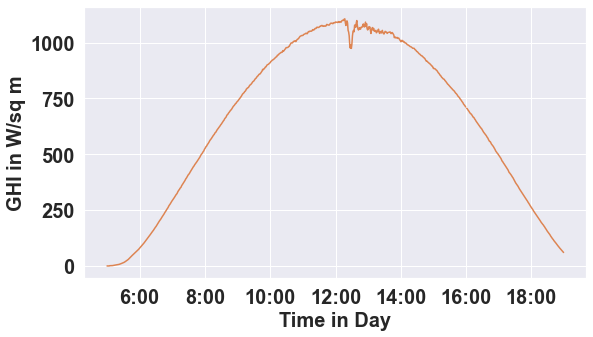

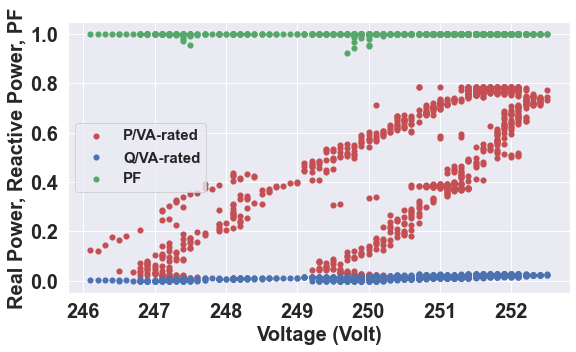

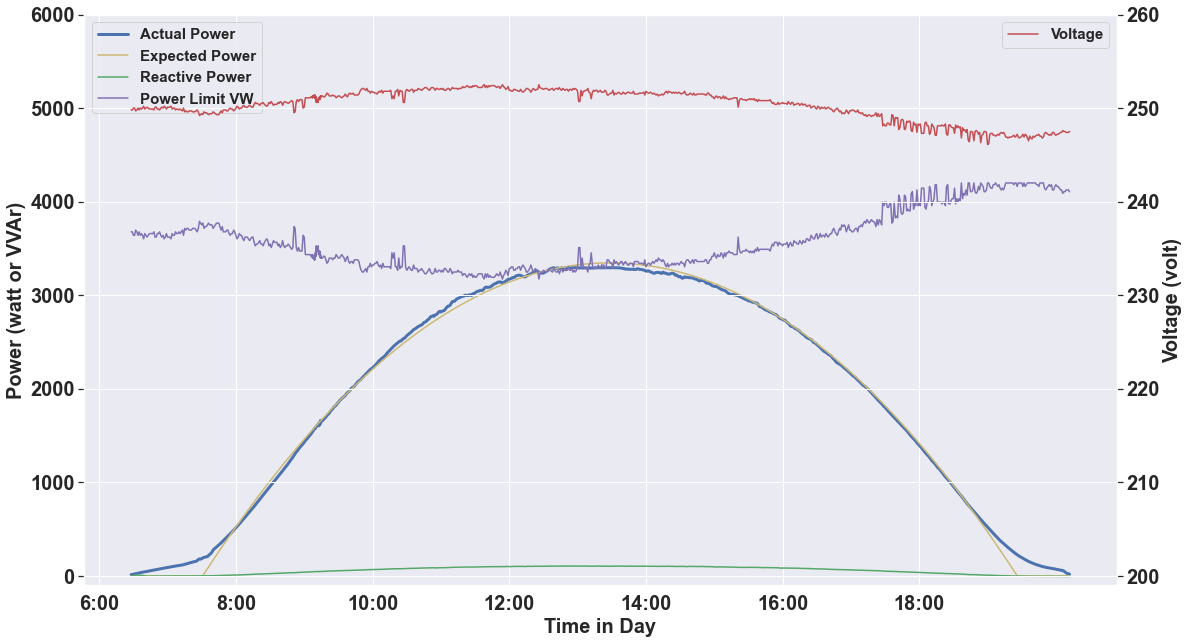

In [11]:
file_path = r"/Users/samhan/Downloads/data" #this is for running in Samhan's laptop
#file_path = r"C:\Users\samha\Documents\CANVAS\data" #for running in TETB CEEM09 computer
site_details, unique_cids= input_general_files(file_path)
summary_all_samples = pd.DataFrame()
sample_number = 10
sample_filename = '/data_sample_{}.csv'.format(sample_number)
ghi_filename = '/ghi_sample_{}.csv'.format(sample_number)

data = pd.read_csv(file_path + sample_filename)
size_is_ok = check_data_size(data)
if not size_is_ok:
    print('Cannot analyze sample {} due to incomplete data.'.format(i))
else:
    ghi = pd.read_csv(file_path + ghi_filename, index_col = 0)
    ghi.index = pd.to_datetime(ghi.index)
    pd.to_datetime(data['Timestamp'].str.slice(0, 19, 1))
    data['Timestamp'] = pd.to_datetime(data['Timestamp'].str.slice(0, 19, 1))
    data.set_index('Timestamp', inplace=True)

    c_id = data['c_id'][0]
    date = str(data.index[0])[:10]

    data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = site_organize(c_id, site_details, data, unique_cids)
    data_site = resample_in_minute(data_site)

    #check the expected power using polyfit
    data_site, polyfit, is_good_polyfit_quality = check_polyfit(data_site, ac_cap)
    #data_site, a, is_good_polyfit_quality = check_polyfit_constrained(data_site, ac_cap)

    is_clear_sky_day = check_clear_sky_day(date)
    tripping_response, tripping_curt_energy, estimation_method, data_site = check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
    energy_generated, data_site = check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)
    vvar_response, vvar_curt_energy, data_site = check_vvar_curtailment(c_id, date, data_site, ghi, ac_cap, dc_cap, EFF_SYSTEM, is_clear_sky_day)
    data_site, vwatt_response, vwatt_curt_energy = check_vwatt_curtailment(data_site, date, is_good_polyfit_quality)

    energy_generated_expected, estimation_method = check_energy_expected(energy_generated, tripping_curt_energy, vvar_curt_energy, vwatt_curt_energy, is_clear_sky_day)
    
    summary = summarize_result_into_dataframe(c_id, date, is_clear_sky_day, energy_generated, energy_generated_expected, estimation_method, tripping_response, tripping_curt_energy, vvar_response, vvar_curt_energy, vwatt_response, vwatt_curt_energy)
    
    display(summary)
    display_ghi(ghi)
    display_power_scatter(data_site)
    display_power_voltage(data_site)

# TESTING FOR SOME SAMPLES
This must be done if a major change has been made to ensure whether there is no problem with the script

Analyzing sample 1 ...


C:\Users\samha\AppData\Local\Temp\ipykernel_13640\478416442.py:634: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m,c = np.linalg.lstsq(A,y)[0]


,c_id,date,clear sky day,energy generated (kWh),expected energy generated (kWh),estimation method,tripping response,tripping curtailment (kWh),V-VAr response,V-VAr curtailment (kWh),V-Watt response,V-Watt curtailment (kWh)
0,1317822057,2019-09-03,False,11.227399,16.042172,Linear,Yes,4.814773,Yes,0.0,Inconclusive due to non clear sky day.,NaN


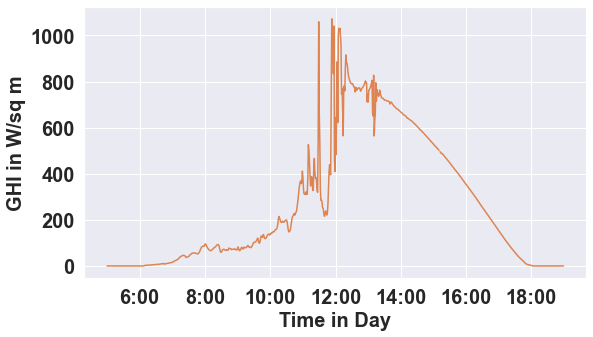

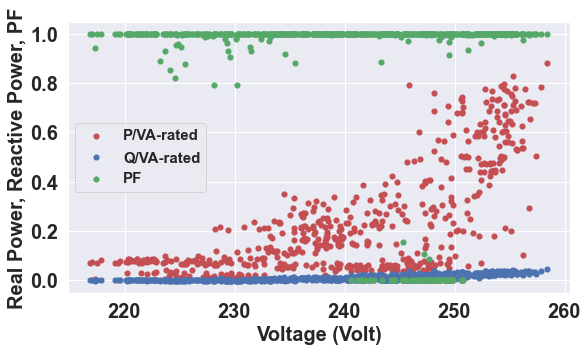

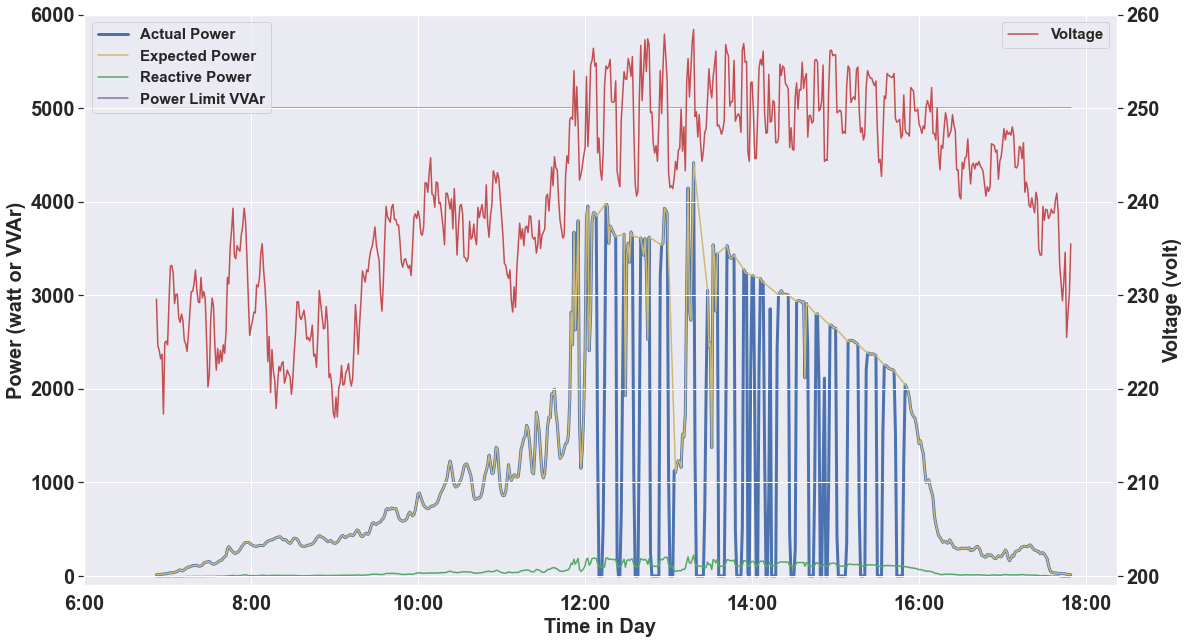

Analyzing sample 11 ...


C:\Users\samha\AppData\Local\Temp\ipykernel_13640\478416442.py:634: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m,c = np.linalg.lstsq(A,y)[0]


,c_id,date,clear sky day,energy generated (kWh),expected energy generated (kWh),estimation method,tripping response,tripping curtailment (kWh),V-VAr response,V-VAr curtailment (kWh),V-Watt response,V-Watt curtailment (kWh)
0,2084803628,2020-01-17,True,28.463915,33.126945,Polyfit,Yes,4.66303,Yes,0.0,None,0


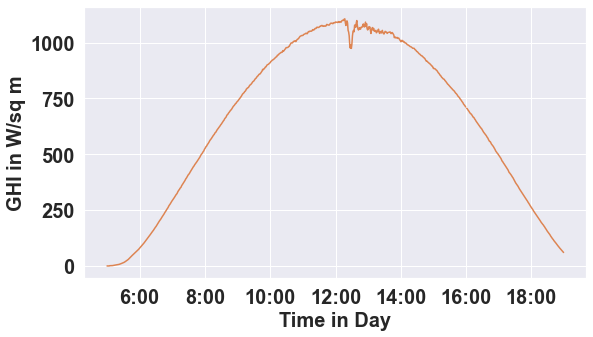

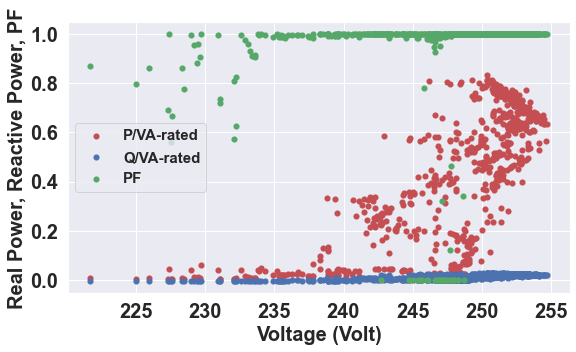

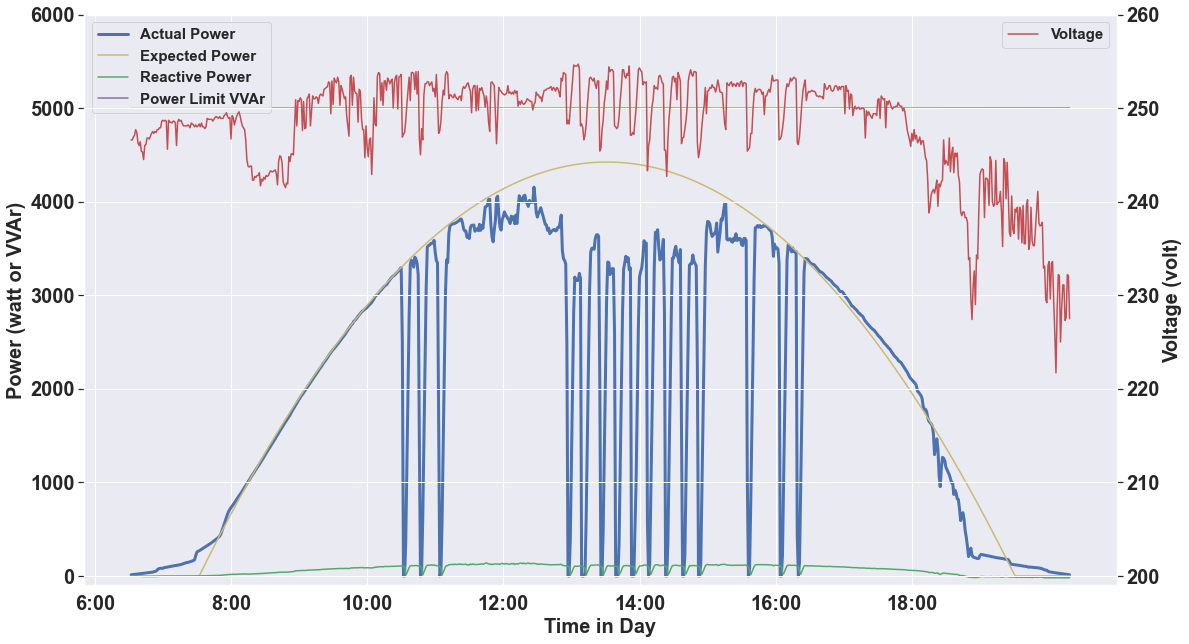

Analyzing sample 14 ...


,c_id,date,clear sky day,energy generated (kWh),expected energy generated (kWh),estimation method,tripping response,tripping curtailment (kWh),V-VAr response,V-VAr curtailment (kWh),V-Watt response,V-Watt curtailment (kWh)
0,173654980,2020-01-17,True,41.922012,45.095014,Polyfit,None,0,Yes,3.173002,None,0


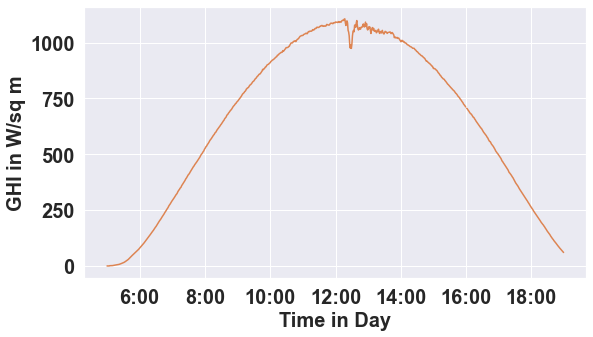

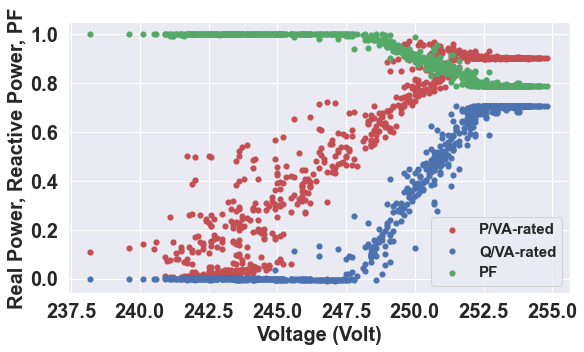

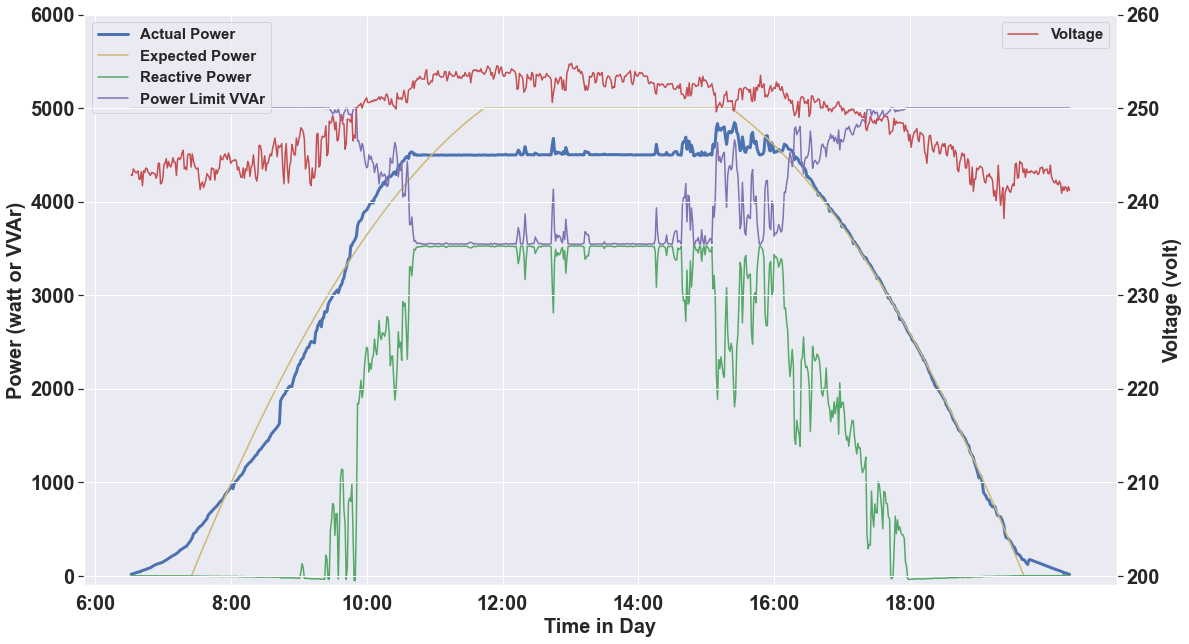

Analyzing sample 4 ...


,c_id,date,clear sky day,energy generated (kWh),expected energy generated (kWh),estimation method,tripping response,tripping curtailment (kWh),V-VAr response,V-VAr curtailment (kWh),V-Watt response,V-Watt curtailment (kWh)
0,1165442853,2020-04-13,True,31.951955,36.438555,Polyfit,None,0,Yes,0.0,Yes,4.4866


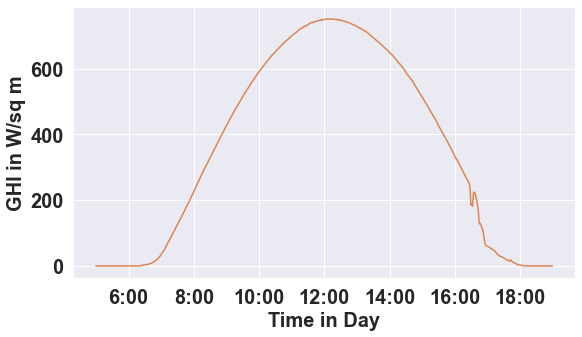

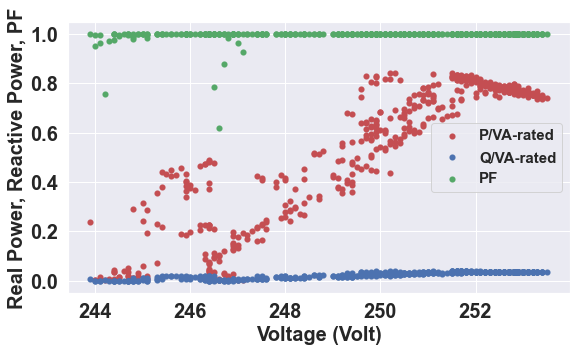

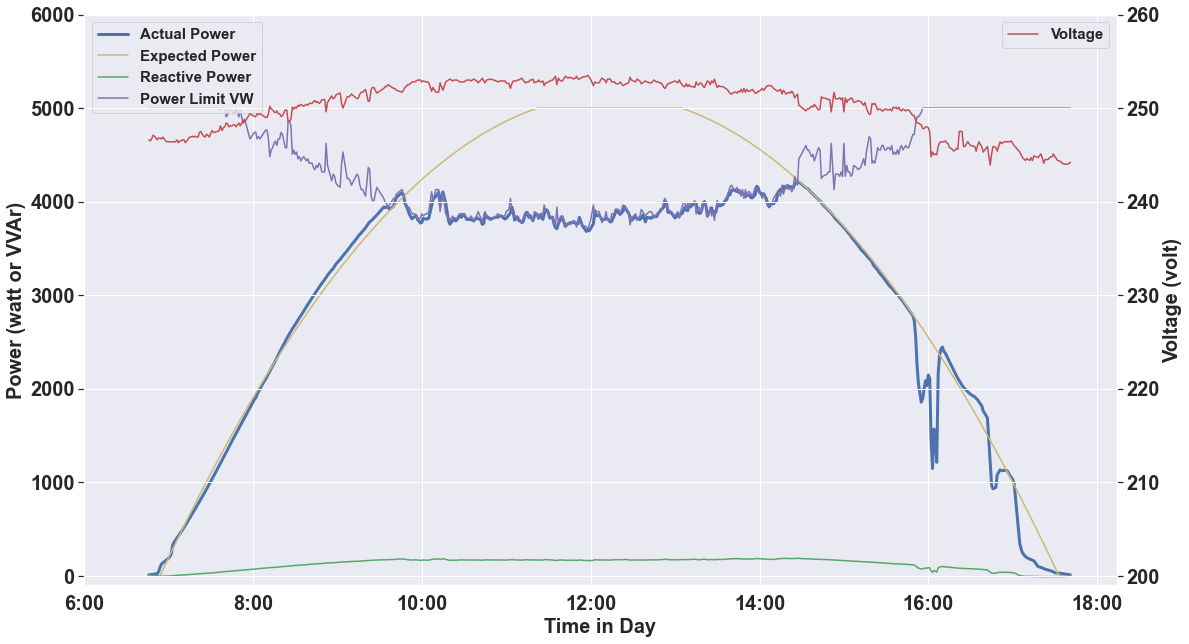

Analyzing sample 5 ...
Cannot analyze sample 5 due to incomplete data.
Analyzing sample 8 ...


,c_id,date,clear sky day,energy generated (kWh),expected energy generated (kWh),estimation method,tripping response,tripping curtailment (kWh),V-VAr response,V-VAr curtailment (kWh),V-Watt response,V-Watt curtailment (kWh)
0,1700492033,2020-01-17,True,22.965787,23.011701,Polyfit,None,0,Yes,0.045914,None,0


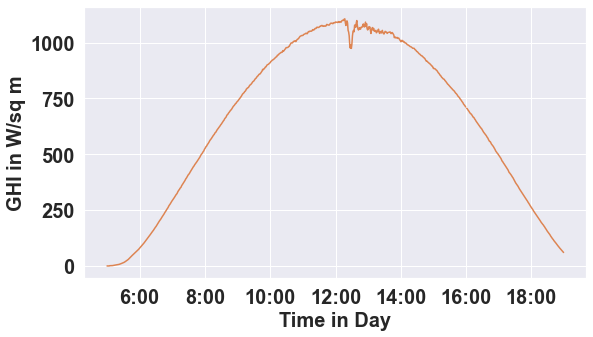

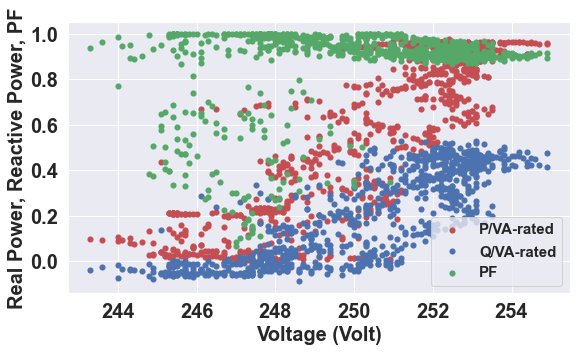

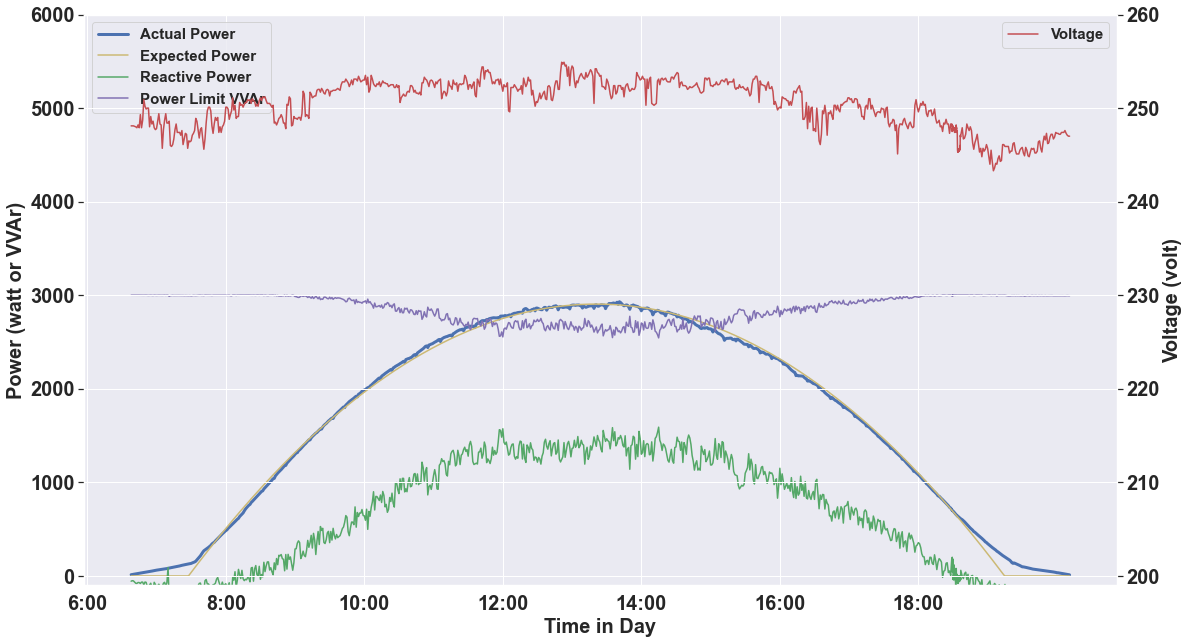

In [21]:
#file_path = r"/Users/samhan/Downloads/data" #this is for running in Samhan's laptop
file_path = r"C:\Users\samha\Documents\CANVAS\data" #for running in TETB CEEM09 computer
site_details, unique_cids= input_general_files(file_path)
summary_all_samples = pd.DataFrame()
avail_sample_number = 14 #this is number of available samples
#for i in list(range(1,14)): 
for i in [1, 11, 14, 4, 5, 8]: 
    sample_number = i
    print('Analyzing sample {} ...'.format(sample_number))
    sample_filename = '/data_sample_{}.csv'.format(sample_number)
    ghi_filename = '/ghi_sample_{}.csv'.format(sample_number)

    data = pd.read_csv(file_path + sample_filename)
    size_is_ok = check_data_size(data)
    if not size_is_ok:
        print('Cannot analyze sample {} due to incomplete data.'.format(i))
    else:
        ghi = pd.read_csv(file_path + ghi_filename, index_col = 0)
        ghi.index = pd.to_datetime(ghi.index)
        pd.to_datetime(data['Timestamp'].str.slice(0, 19, 1))
        data['Timestamp'] = pd.to_datetime(data['Timestamp'].str.slice(0, 19, 1))
        data.set_index('Timestamp', inplace=True)

        c_id = data['c_id'][0]
        date = str(data.index[0])[:10]

        data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = site_organize(c_id, site_details, data, unique_cids)
        data_site = resample_in_minute(data_site)

        #check the expected power using polyfit
        data_site, polyfit, is_good_polyfit_quality = check_polyfit(data_site, ac_cap)
        #data_site, a, is_good_polyfit_quality = check_polyfit_constrained(data_site, ac_cap)


        is_clear_sky_day = check_clear_sky_day(date)
        tripping_response, tripping_curt_energy, estimation_method, data_site = check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
        energy_generated, data_site = check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)
        vvar_response, vvar_curt_energy, data_site = check_vvar_curtailment(c_id, date, data_site, ghi, ac_cap, dc_cap, EFF_SYSTEM, is_clear_sky_day)
        data_site, vwatt_response, vwatt_curt_energy = check_vwatt_curtailment(data_site, date, is_good_polyfit_quality)

        energy_generated_expected, estimation_method = check_energy_expected(energy_generated, tripping_curt_energy, vvar_curt_energy, vwatt_curt_energy, is_clear_sky_day)

        summary = summarize_result_into_dataframe(c_id, date, is_clear_sky_day, energy_generated, energy_generated_expected, estimation_method, tripping_response, tripping_curt_energy, vvar_response, vvar_curt_energy, vwatt_response, vwatt_curt_energy)

        display(summary)
        display_ghi(ghi)
        display_power_scatter(data_site)
        display_power_voltage(data_site)

# ---- MAIN PROGRAM ENDS HERE -----

# OTHER PLOTS

,c_id,date,clear sky day,energy generated (kWh),expected energy generated (kWh),estimation method,tripping response,tripping curtailment (kWh),V-VAr response,V-VAr curtailment (kWh),V-Watt response,V-Watt curtailment (kWh)
0,1165442853,2020-04-13,True,31.951955,36.438596,Polyfit,None,0,Yes,0.0,Yes,4.48664


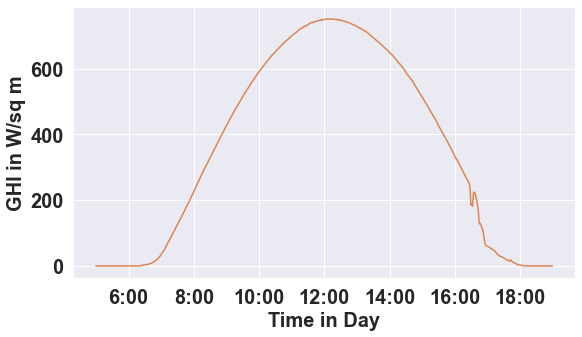

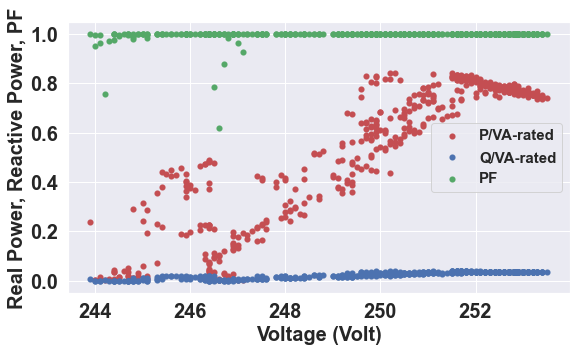

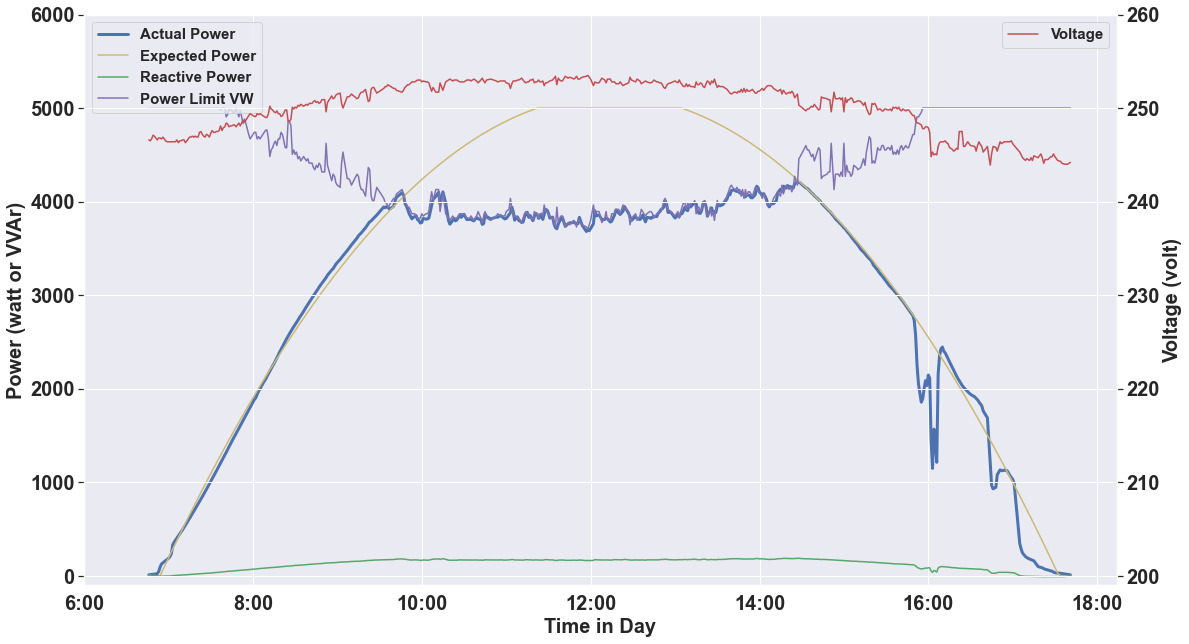

In [12]:
file_path = r"/Users/samhan/Downloads/data" #this is for running in Samhan's laptop
#file_path = r"C:\Users\samha\Documents\CANVAS\data" #for running in TETB CEEM09 computer
site_details, unique_cids= input_general_files(file_path)
summary_all_samples = pd.DataFrame()
sample_number = 4
sample_filename = '/data_sample_{}.csv'.format(sample_number)
ghi_filename = '/ghi_sample_{}.csv'.format(sample_number)

data = pd.read_csv(file_path + sample_filename)
size_is_ok = check_data_size(data)
if not size_is_ok:
    print('Cannot analyze sample {} due to incomplete data.'.format(i))
else:
    ghi = pd.read_csv(file_path + ghi_filename, index_col = 0)
    ghi.index = pd.to_datetime(ghi.index)
    pd.to_datetime(data['Timestamp'].str.slice(0, 19, 1))
    data['Timestamp'] = pd.to_datetime(data['Timestamp'].str.slice(0, 19, 1))
    data.set_index('Timestamp', inplace=True)

    c_id = data['c_id'][0]
    date = str(data.index[0])[:10]

    data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = site_organize(c_id, site_details, data, unique_cids)
    data_site = resample_in_minute(data_site)

    #check the expected power using polyfit
    data_site, polyfit, is_good_polyfit_quality = check_polyfit(data_site, ac_cap)
    #data_site, a, is_good_polyfit_quality = check_polyfit_constrained(data_site, ac_cap)

    is_clear_sky_day = check_clear_sky_day(date)
    tripping_response, tripping_curt_energy, estimation_method, data_site = check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
    energy_generated, data_site = check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)
    vvar_response, vvar_curt_energy, data_site = check_vvar_curtailment(c_id, date, data_site, ghi, ac_cap, dc_cap, EFF_SYSTEM, is_clear_sky_day)
    data_site, vwatt_response, vwatt_curt_energy = check_vwatt_curtailment(data_site, date, is_good_polyfit_quality)

    energy_generated_expected, estimation_method = check_energy_expected(energy_generated, tripping_curt_energy, vvar_curt_energy, vwatt_curt_energy, is_clear_sky_day)
    
    summary = summarize_result_into_dataframe(c_id, date, is_clear_sky_day, energy_generated, energy_generated_expected, estimation_method, tripping_response, tripping_curt_energy, vvar_response, vvar_curt_energy, vwatt_response, vwatt_curt_energy)
    
    display(summary)
    display_ghi(ghi)
    display_power_scatter(data_site)
    display_power_voltage(data_site)

In [16]:
"""Check whether the inverter shows vwatt response or not.
    
This function will be done in a loop over Vlimit 235 - 255 V.
Steps:
1. Make a power limit value based on VW curve
2. Filter voltage and power, which is curtailed (expected power from polyfit is higher than allowed voltage)
3. Count the percentage of datapoints from previous step in the buffer range of VWatt curve
4. If the percentage from the previous step is higher than certain limit, we say it shows VWatt response.

Args:
    data_site (df) : D-PV time series data
    polyfit(polyfit): a funciton to map timestamp value to expected power without curtailment

Returns:
    vwatt_response (str) : Yes, None, or Inconclusive due to insufficient overvoltage datapoint.

TODO: 
1. Reassess whether it is necessary to determine VWatt using count and gradient threshold
2. Test for non VWatt sample & inconclusive sample
"""

global best_percentage, best_count, best_Vlimit, vwatt_data
#for Vlimit in list(range (246, 258)): #This is from Tim. Tim's range is different, which IDK why.
best_percentage = 0 #initiation
Vlimit = 248
#step 1. Make a power limit value based on VW curve
data_site['power_limit_vw'] = data_site['voltage'].apply(volt_watt_curve, limit = Vlimit) * ac_cap

#step 2. Filter voltage and power, which is curtailed (expected power from polyfit is higher than allowed voltage)
global suspect_data, vwatt_data
suspect_data_filter = data_site['power_limit_vw'] < data_site['power_expected'] 
suspect_data = pd.DataFrame()
suspect_data = data_site[suspect_data_filter].copy()

#step 3. Count the percentage of datapoints from previous step in the buffer range of VWatt curve

#create the buffer range
BUFFER_HIGH_VAL =  150 #This is from Tim's thesis. In Tim's program the used value is 0.035 * ac_cap but IDK it doesn't work well.
BUFFER_LOW_VAL = 150  #This is from Tim's thesis. In Tim's program the used value is 0.08 * ac_cap but IDK it doesn't work well.
buffer_high_filter = suspect_data['power_relative'] > 0.9
buffer_low_filter = ~buffer_high_filter

pd.options.mode.chained_assignment = None  # default='warn'
suspect_data.loc[buffer_high_filter, 'power_limit_upper'] = suspect_data['power_limit_vw'] + BUFFER_HIGH_VAL
suspect_data.loc[buffer_high_filter, 'power_limit_lower'] = suspect_data['power_limit_vw'] - BUFFER_HIGH_VAL

suspect_data.loc[buffer_low_filter, 'power_limit_upper'] = suspect_data['power_limit_vw'] + BUFFER_LOW_VAL
suspect_data.loc[buffer_low_filter, 'power_limit_lower'] = suspect_data['power_limit_vw'] - BUFFER_LOW_VAL

#count points in buffer
is_low_ok = suspect_data['power_limit_lower'] < suspect_data['power']
is_upp_ok = suspect_data['power'] < suspect_data['power_limit_upper']
suspect_data['is_in_buffer_range'] = is_low_ok & is_upp_ok
count_in_buffer_range = suspect_data['is_in_buffer_range'].values.sum() #count true in a col
try:
    percentage_in_buffer_range = float(count_in_buffer_range) / float(len(suspect_data.index)) * 100
    #put the best VWLimit stats
    if percentage_in_buffer_range > best_percentage or best_percentage == 0:
        best_percentage = percentage_in_buffer_range
        best_count = count_in_buffer_range
        best_Vlimit = Vlimit
        vwatt_data = suspect_data
except:
    pass

data_site['power_limit_vw'] = data_site['voltage'].apply(volt_watt_curve, limit = best_Vlimit) * ac_cap

#step 4. If the percentage from the previous step is higher than certain limit, we say it shows VWatt response.
PERCENTAGE_THRESHOLD = 84
COUNT_THRESHOLD = 30 #Tim uses 150 for a month data, where a month usually consist of around 5 clear sky days.
#print(best_percentage)
#print (best_Vlimit)
if (best_percentage > PERCENTAGE_THRESHOLD) & (best_count > COUNT_THRESHOLD): #Tim uses count threshold and gradient threshold. I am not sure whether it is necessary.
    vwatt_response = 'Yes'
    vwatt_curt_energy = check_energy_curtailed(vwatt_data)
elif suspect_data['voltage'].max() < 255:
    vwatt_response = 'Inconclusive due to insufficient data points'
    vwatt_curt_energy = float('nan')
else: #no Vlimit results a good fit in all possible Vlimit value
    vwatt_response = 'None'
    vwatt_curt_energy = 0

In [17]:
suspect_data

,c_id,energy,power,reactive_power,voltage,duration,va,pf,power_relative,power_expected,power_limit_vv,power_limit_vw,power_normalized,var_normalized,power_limit_upper,power_limit_lower,is_in_buffer_range
ts,,,,,,,,,,,,,,,,,
2020-04-13 09:47:55,1165442853,239108,3985.133333,178.750000,252.2,60,3989.140164,0.998996,0.797027,4068.640625,4996.803822,4011.764706,0.797027,0.035750,4161.764706,3861.764706,True
2020-04-13 09:49:55,1165442853,235140,3919.000000,173.466667,252.5,60,3922.837198,0.999022,0.783800,4097.683594,4996.990026,3941.176471,0.783800,0.034693,4091.176471,3791.176471,True
2020-04-13 09:50:55,1165442853,232325,3872.083333,171.500000,252.5,60,3875.879460,0.999021,0.774417,4112.054688,4997.057909,3941.176471,0.774417,0.034300,4091.176471,3791.176471,True
2020-04-13 09:52:55,1165442853,228955,3815.916667,169.883333,252.8,60,3819.696369,0.999010,0.763183,4140.492188,4997.113132,3870.588235,0.763183,0.033977,4020.588235,3720.588235,True
2020-04-13 09:53:55,1165442853,230069,3834.483333,170.966667,252.8,60,3838.292854,0.999007,0.766897,4154.566406,4997.076185,3870.588235,0.766897,0.034193,4020.588235,3720.588235,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-13 14:20:55,1165442853,249056,4150.933333,186.166667,251.7,60,4155.105963,0.998996,0.830187,4312.929688,4996.532995,4129.411765,0.830187,0.037233,4279.411765,3979.411765,True
2020-04-13 14:21:55,1165442853,249617,4160.283333,185.433333,251.6,60,4164.413876,0.999008,0.832057,4300.046875,4996.560265,4152.941176,0.832057,0.037087,4302.941176,4002.941176,True
2020-04-13 14:22:55,1165442853,249337,4155.616667,185.300000,251.8,60,4159.745902,0.999007,0.831123,4287.062500,4996.565211,4105.882353,0.831123,0.037060,4255.882353,3955.882353,True


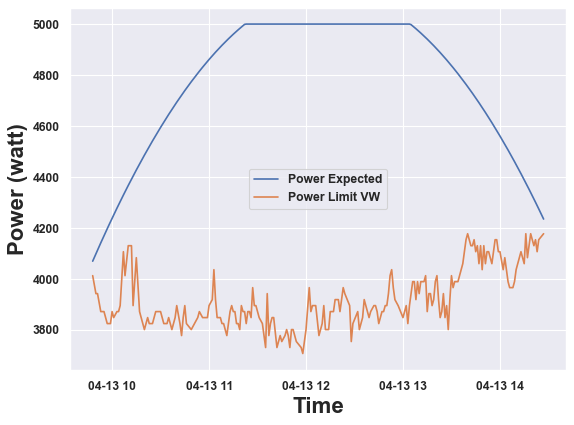

In [26]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(suspect_data['power_expected'], label = 'Power Expected')
plt.plot(suspect_data['power_limit_vw'], label = 'Power Limit VW')
time_range = range(3,10)
plt.xlabel('Time', **fontdict)
plt.ylabel('Power (watt)', **fontdict)
plt.legend()

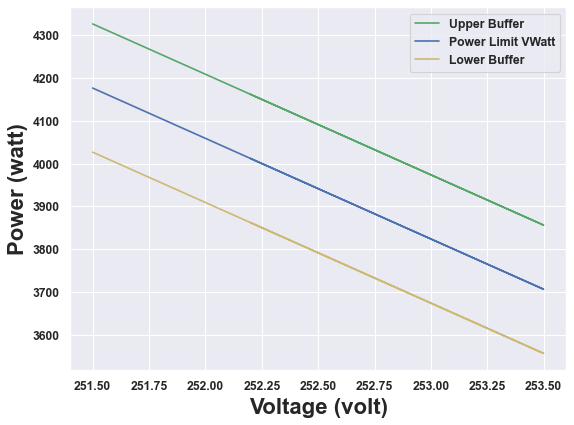

In [41]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(suspect_data['voltage'], suspect_data['power_limit_upper'], label = 'Upper Buffer', color = 'g')
plt.plot(suspect_data['voltage'], suspect_data['power_limit_vw'], label = 'Power Limit VWatt', color = 'b')
plt.plot(suspect_data['voltage'], suspect_data['power_limit_lower'], label = 'Lower Buffer', color = 'y')
time_range = range(3,10)
plt.xlabel('Voltage (volt)', **fontdict)
plt.ylabel('Power (watt)', **fontdict)
plt.legend()

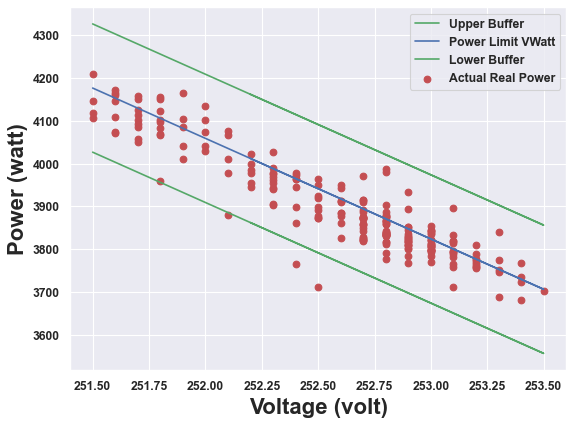

In [38]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(suspect_data['voltage'], suspect_data['power_limit_upper'], label = 'Upper Buffer', color = 'g')
plt.plot(suspect_data['voltage'], suspect_data['power_limit_vw'], label = 'Power Limit VWatt')
plt.plot(suspect_data['voltage'], suspect_data['power_limit_lower'], label = 'Lower Buffer', color = 'g')
plt.scatter(suspect_data['voltage'], suspect_data['power'], label = 'Actual Real Power', color = 'r')
time_range = range(3,10)
plt.xlabel('Voltage (volt)', **fontdict)
plt.ylabel('Power (watt)', **fontdict)
plt.legend()

# MESSY BELOW

In [14]:
ghi

,sl,Station Number,Year Month Day Hours Minutes in YYYY,MM,DD,HH24,MI format in Local standard time,Mean global irradiance (over 1 minute) in W/sq m,Minimum 1 second global irradiance (over 1 minute) in W/sq m,Maximum 1 second global irradiance (over 1 minute) in W/sq m,...,Uncertainty in mean terrestrial irradiance (over 1 minute) in W/sq m,Mean direct horizontal irradiance (over 1 minute) in W/sq m,Minimum 1 second direct horizontal irradiance (over 1 minute) in W/sq m,Maximum 1 second direct horizontal irradiance (over 1 minute) in W/sq m,Standard deviation of direct horizontal irradiance (over 1 minute) in W/sq m,Uncertainty in mean direct horizontal irradiance (over 1 minute) in W/sq m,Sunshine-seconds-96 (duration of DNI exceeding 96 W/sq m over 1 minute) in seconds,Sunshine-seconds-120 (duration of DNI exceeding 120 W/sq m over 1 minute) in seconds,Sunshine-seconds-144 (duration of DNI exceeding 144 W/sq m over 1 minute) in seconds,Zenith distance in degrees
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-17 00:00:00,sl,23034,2020,1,17,0,0,0.0,0.00,0.00,...,,0.00,0.00,0.00,0.00,,0,0,0,0.00
2020-01-17 00:01:00,sl,23034,2020,1,17,0,1,0.0,0.00,0.00,...,,0.00,0.00,0.00,0.00,,0,0,0,0.00
2020-01-17 00:02:00,sl,23034,2020,1,17,0,2,0.0,0.00,0.00,...,,0.00,0.00,0.00,0.00,,0,0,0,0.00
2020-01-17 00:03:00,sl,23034,2020,1,17,0,3,0.0,0.00,0.00,...,,0.00,0.00,0.00,0.00,,0,0,0,0.00
2020-01-17 00:04:00,sl,23034,2020,1,17,0,4,0.0,0.00,0.00,...,,0.00,0.00,0.00,0.00,,0,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-17 23:55:00,sl,23034,2020,1,17,23,55,0.0,0.00,0.00,...,,0.00,0.00,0.00,0.00,,0,0,0,0.00
2020-01-17 23:56:00,sl,23034,2020,1,17,23,56,0.0,0.00,0.00,...,,0.00,0.00,0.00,0.00,,0,0,0,0.00
2020-01-17 23:57:00,sl,23034,2020,1,17,23,57,0.0,0.00,0.00,...,,0.00,0.00,0.00,0.00,,0,0,0,0.00


In [15]:
ghi_cleaned = ghi[['Mean global irradiance (over 1 minute) in W/sq m']].copy()

In [17]:
filter_zero = ghi_cleaned['Mean global irradiance (over 1 minute) in W/sq m'] != 0

In [18]:
ghi_cleaned[filter_zero]

,Mean global irradiance (over 1 minute) in W/sq m
timestamp,
2020-01-17 05:05:00,1.14
2020-01-17 05:06:00,1.19
2020-01-17 05:07:00,1.28
2020-01-17 05:08:00,1.42
2020-01-17 05:09:00,1.30
...,...
2020-01-17 19:44:00,1.73
2020-01-17 19:45:00,1.60
2020-01-17 19:46:00,1.39
